# Suhani's Spotify Wrapped Analysis

## Executive Summary

This comprehensive analysis explores my personal Spotify listening data spanning from 2018 to 2023, providing insights into my music consumption patterns, preferences, and evolution over time. Key findings include:

- **Total Listening Time**: Over 3,500 hours (149 days) of music consumption since 2018
- **Favorite Artist**: BTS dominates my listening history with "ON" as my all-time most-played song
- **Peak Usage**: Highest listening activity occurred between 2019-2020
- **Geographic Patterns**: Music consumption while traveling across multiple countries
- **Temporal Trends**: Listening patterns show seasonal and life-event correlations

## Methodology

This analysis uses personal Spotify streaming data obtained through Spotify's data export feature, combined with Spotify Web API for additional track metadata. Data processing includes cleaning, deduplication, and enrichment with audio features for deeper insights.

---

This is my personal project where I explore my Spotify data for the years 2022 to 2023 and try and understand what I can about my own data and song preferences. 

## Configuration and Setup

First, let's set up our configuration and import necessary packages. For security, we'll use environment variables for API credentials.

In [132]:
import json
import csv
import pandas as pd
# import babypandas as bpd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import warnings

# Machine learning / clustering imports
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Configuration
DATA_DIR = 'Spotify Account Data'
EXTENDED_DATA_DIR = 'Spotify Extended Streaming History'

# API Configuration (use environment variables for security)
SPOTIFY_USERNAME = os.getenv('SPOTIFY_USERNAME', 'sm.army')
SPOTIFY_CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID', '')
SPOTIFY_CLIENT_SECRET = os.getenv('SPOTIFY_CLIENT_SECRET', '')
REDIRECT_URI = 'http://localhost:7777/callback'

# Helper Functions
def convert_ms_to_hours(milliseconds):
    """Convert milliseconds to hours"""
    return milliseconds / (1000 * 60 * 60)

def convert_ms_to_days(milliseconds):
    """Convert milliseconds to days"""
    return milliseconds / (1000 * 60 * 60 * 24)

def create_enhanced_barplot(data, x_col, y_col, title, xlabel, ylabel, 
                           figsize=(12, 8), color_scheme='viridis'):
    """Create an enhanced horizontal bar plot with consistent styling"""
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create color gradient
    colors = plt.cm.get_cmap(color_scheme)(np.linspace(0, 1, len(data)))
    
    bars = ax.barh(data[x_col], data[y_col], color=colors)
    
    # Customize the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, data[y_col])):
        ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{int(value)}', ha='left', va='center', fontweight='bold')
    
    ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Improve tick formatting
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', labelsize=10)
    
    # Add grid for better readability
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    return fig, ax

def print_summary_stats(df, column, name="Data"):
    """Print summary statistics for a column"""
    print(f"\n=== {name} Summary Statistics ===")
    print(f"Count: {df[column].count():,}")
    print(f"Mean: {df[column].mean():.2f}")
    print(f"Median: {df[column].median():.2f}")
    print(f"Min: {df[column].min():.2f}")
    print(f"Max: {df[column].max():.2f}")
    print(f"Standard Deviation: {df[column].std():.2f}")

## File Background Information
I downloaded this information from my Spotify account. For the record this is only the last couple of years because it is not the comprehensive data download. 
As I have been using Spotify since 2018 I anticipate that it will take longer for them to get that information to me. 
'streaming0' contains all the information from the end of the 2022 collection year. This spans from November 30th, 2022 up until October 25th, 2023. <br>
'streaming1' contains everything I have listened to since October 25th, 2023 until December 1st, 2023 which would coincide with the date that this data was delivered to me.

In [133]:
streaming1 = pd.read_json('Spotify Account Data/StreamingHistory1.json')
streaming1.to_csv('Streaming1.csv')
streaming0 = pd.read_json('Spotify Account Data/StreamingHistory0.json')
streaming0.to_csv('Streaming0.csv')

Below we see the two data frames. The first thing I notice is that 'streaming0' seems to stop at 10,000 rows which I find interesting that it is a rounded number. I do not know if that is a conincidence or a specific choice by Spotify in how they package the 'abridged' data package. 

In [134]:
streaming0

,endTime,artistName,trackName,msPlayed
0,2022-11-30 20:22,Little Mix,No,181587
1,2022-12-01 09:47,BTS,Run BTS,204939
2,2022-12-01 09:48,SF9,O Sole Mio,17287
3,2022-12-01 09:51,TOMORROW X TOGETHER,Good Boy Gone Bad,191038
4,2022-12-01 09:54,NCT DREAM,BOOM,195080
...,...,...,...,...
9995,2023-10-25 22:36,KAI,Rover,174506
9996,2023-10-25 22:39,MONSTA X,WHO DO U LOVE? (feat. French Montana),189035
9997,2023-10-25 22:42,BLACKPINK,PLAYING WITH FIRE,197288
9998,2023-10-25 22:43,JENNIE,You & Me,37441


In [135]:
streaming1

,endTime,artistName,trackName,msPlayed
0,2023-10-25 23:03,MONSTA X,WHO DO U LOVE? (feat. French Montana),26476
1,2023-10-26 01:56,KAI,Rover,174506
2,2023-10-26 01:59,MONSTA X,WHO DO U LOVE? (feat. French Montana),189035
3,2023-10-26 02:02,JENNIE,You & Me,15312
4,2023-10-26 02:02,BLACKPINK,PLAYING WITH FIRE,197288
...,...,...,...,...
3284,2023-12-01 20:44,Beyoncé,Deja Vu (feat. Jay-Z) - Homecoming Live,289790
3285,2023-12-01 20:47,Beyoncé,Deja Vu (feat. Jay-Z) - Homecoming Live,158360
3286,2023-12-01 20:57,Beyoncé,Deja Vu (feat. Jay-Z) - Homecoming Live,5560
3287,2023-12-01 22:56,Beyoncé,Deja Vu (feat. Jay-Z) - Homecoming Live,284529


To make it easier to work with these data frames I am going to combine them into a single data frame that I will call 'streaming' so that it represents the entire listening year for 2023. <br> First I define a list of both the data frame names to contain both years. Then we define the new data frame as the concatenation of the list of data frames stored in 'both_years'. <br> Note: The order of the data frame are listed such that the new data frame remains in chronological order.

In [136]:
both_years = [streaming0, streaming1]
streaming = pd.concat(both_years)

Now we can see all the songs I have listened to since November 30th, 2022. 

In [137]:
streaming

,endTime,artistName,trackName,msPlayed
0,2022-11-30 20:22,Little Mix,No,181587
1,2022-12-01 09:47,BTS,Run BTS,204939
2,2022-12-01 09:48,SF9,O Sole Mio,17287
3,2022-12-01 09:51,TOMORROW X TOGETHER,Good Boy Gone Bad,191038
4,2022-12-01 09:54,NCT DREAM,BOOM,195080
...,...,...,...,...
3284,2023-12-01 20:44,Beyoncé,Deja Vu (feat. Jay-Z) - Homecoming Live,289790
3285,2023-12-01 20:47,Beyoncé,Deja Vu (feat. Jay-Z) - Homecoming Live,158360
3286,2023-12-01 20:57,Beyoncé,Deja Vu (feat. Jay-Z) - Homecoming Live,5560
3287,2023-12-01 22:56,Beyoncé,Deja Vu (feat. Jay-Z) - Homecoming Live,284529


## My Listening History with BTS

BTS has been one of my all-time favorite artists consistently over the past few years. The reason I downloaded Spotify at all was to be able to listen to their music while also multi-tasking. <br>
Until I get more data this will just be my initial exploration of what I can do with this information and then we can do a more comprehensive review once I get my extended data package. <br>
I intend to get a better understanding of the amount of time I spend listening to BTS songs. 

First I query out all the times I listened to BTS:

In [138]:
bts = streaming[streaming['artistName']=='BTS']

The following code determines the number of rows in the bts dataframe which is equivalent to the number of times I have listened to any BTS song. 

In [139]:
total_bts = bts.shape[0]
print('The number of times I have listened to any BTS song is: ' + str(total_bts))

The number of times I have listened to any BTS song is: 1095


This line tells me the number of different BTS songs I have listened to.

In [140]:
num_unique = len(bts['trackName'].unique())
print('Over the last year I have listened to ' + str(num_unique) + ' different BTS songs.')

Over the last year I have listened to 112 different BTS songs.


Now I am curious to determine the number of hours I have spent listening to BTS songs. This can be done by querying out the 'msPlayed' column and converting its sum from milliseconds into hours. <br>
Note: I have created intermediate variables of 'total_s' and 'total_min' in case they become useful later. 

In [141]:
#First we query out the number of miliseconds played.
total_ms = bts['msPlayed'].sum()

#Then we do the following math to determine how many hours 
total_s = total_ms * 0.001
total_min = total_s / 60
total_hrs = total_min / 60

#I will round to two decimal places.
rounded_total_min = np.round(total_min, 1)
rounded_total_hrs = np.round(total_hrs, 2)

print('I have spent about ' + str(rounded_total_min) + ' minutes listening to BTS in the last year.')
print('This is equivalent to about ' + str(int(np.round(rounded_total_hrs))) + ' hours and 2 minutes of BTS in this time frame.')

I have spent about 3122.6 minutes listening to BTS in the last year.
This is equivalent to about 52 hours and 2 minutes of BTS in this time frame.


Now I want to see the distribution of the BTS songs I listened to. First we are going to group the data frame by each song and count the number of times it was played. I'll assign a new column for the number of times each song is played and create a data frame of just the song counts called 'song_counts'.

In [142]:
grouped_by_song = bts.groupby('trackName').count()
song_counts = grouped_by_song.assign(timesPlayed = grouped_by_song['endTime'])
song_counts = song_counts.sort_values('timesPlayed', ascending=False)
song_counts = song_counts.get(['timesPlayed']).reset_index()
song_counts

,trackName,timesPlayed
0,Black Swan,49
1,dimple,38
2,Filter,34
3,Run BTS,33
4,Jamais Vu,31
...,...,...
107,Skit: R U Happy Now?,1
108,Skit: Circle Room Talk,1
109,Begin,1
110,Stay,1


I notice that there are quite a few songs that I only listened to once so I'm going to create a list of song titles that I have only listened to one time. 

In [143]:
one_listen = song_counts[song_counts.get('timesPlayed') == 1]
one_listen = one_listen['trackName']
num_one_listen = one_listen.shape[0]
print('The number of songs I have listened to only once is ' + str(num_one_listen)+ '.')
print(one_listen)

The number of songs I have listened to only once is 28.
84                                               Ma City
85                                            Magic Shop
86                                              Dynamite
87                                         Hip Hop Phile
88     A Brand New Day (BTS World Original Soundtrack...
89                                                 2! 3!
90                                 Intro: Boy Meets Evil
91                                      Intro: O!RUL8,2?
92                                          Just One Day
93                                         Hold Me Tight
94                                                  Like
95                                                  Lost
96                                   Permission to Dance
97                                          Outro: Wings
98                                           Blue & Grey
99                                         Boyz with Fun
100                             

Now I can transform the information such that we can create a pie chart of the amount of times I have listened to the various BTS songs. <br>
We know that the last 28 songs in our data frame were only listened to one time so we can query out the trackName and timesPlayed series and adjust them to put those 28 songs into a category called 'Other'. 

In [144]:
num_tracks = song_counts.shape[0]
tracks = song_counts['trackName']
tracks = tracks[:num_tracks-num_one_listen]
tracks = np.append(tracks, 'Other')
print(tracks)
plays = song_counts['timesPlayed']
plays = plays[:num_tracks-num_one_listen]
plays = np.append(plays, num_one_listen)
print(len(plays))

['Black Swan' 'dimple' 'Filter' 'Run BTS' 'Jamais Vu' 'Make It Right'
 'I Need U' 'FAKE LOVE' 'Best Of Me' 'Friends'
 'Heartbeat (BTS World Original Soundtrack)' 'ON' 'Mikrokosmos' 'Save Me'
 'Pied Piper' 'HOME' 'Go Go' 'Love Maze' 'IDOL' 'Spine Breaker'
 'Answer : Love Myself' 'Converse High' 'Run' 'Intro: Singularity'
 'Lights' 'BTS Cypher 4' 'Intro: Serendipity'
 'We are Bulletproof : the Eternal' 'Euphoria'
 'Boy With Luv (feat. Halsey)' 'Outro: Her'
 'House of Cards - Full Length Edition' 'Trivia 承 : Love'
 'A Supplementary Story: You Never Walk Alone' 'Epilogue: Young Forever'
 '21st Century Girl' 'Louder than bombs' 'Trivia 轉 : Seesaw'
 'Trivia 起 : Just Dance' 'The Truth Untold (feat. Steve Aoki)'
 'Silver Spoon' 'Epiphany'
 'MIC Drop (Steve Aoki Remix) - Full Length Edition' 'Spring Day'
 "I'm Fine" 'My Time' 'Anpanman' 'Outro: Tear' 'Not Today' 'Life Goes On'
 'Butterfly' 'Burning Up (Fire)' 'Jump' 'Butter' 'Telepathy'
 'Airplane pt.2' 'DNA' 'Blood Sweat & Tears' 'Dionysus'
 '

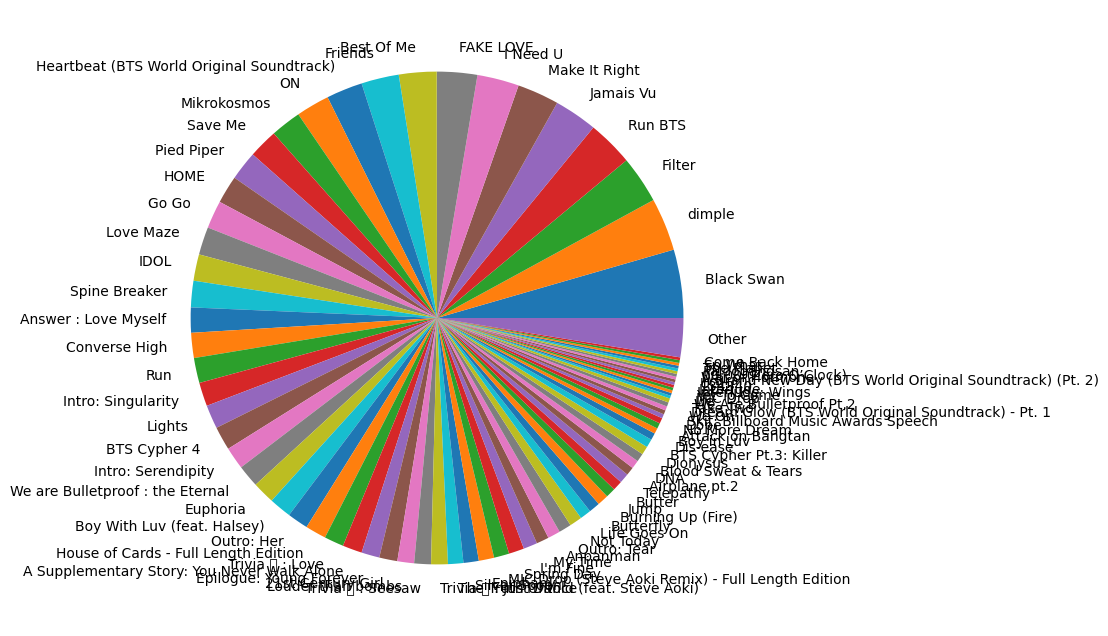

In [145]:
plt.pie(plays, labels = tracks)
plt.show()

Now I notice that this chart is quite difficult to follow just given the sheer number of songs that are included. So we are going to adjust my strategy to a bar chart instead. 

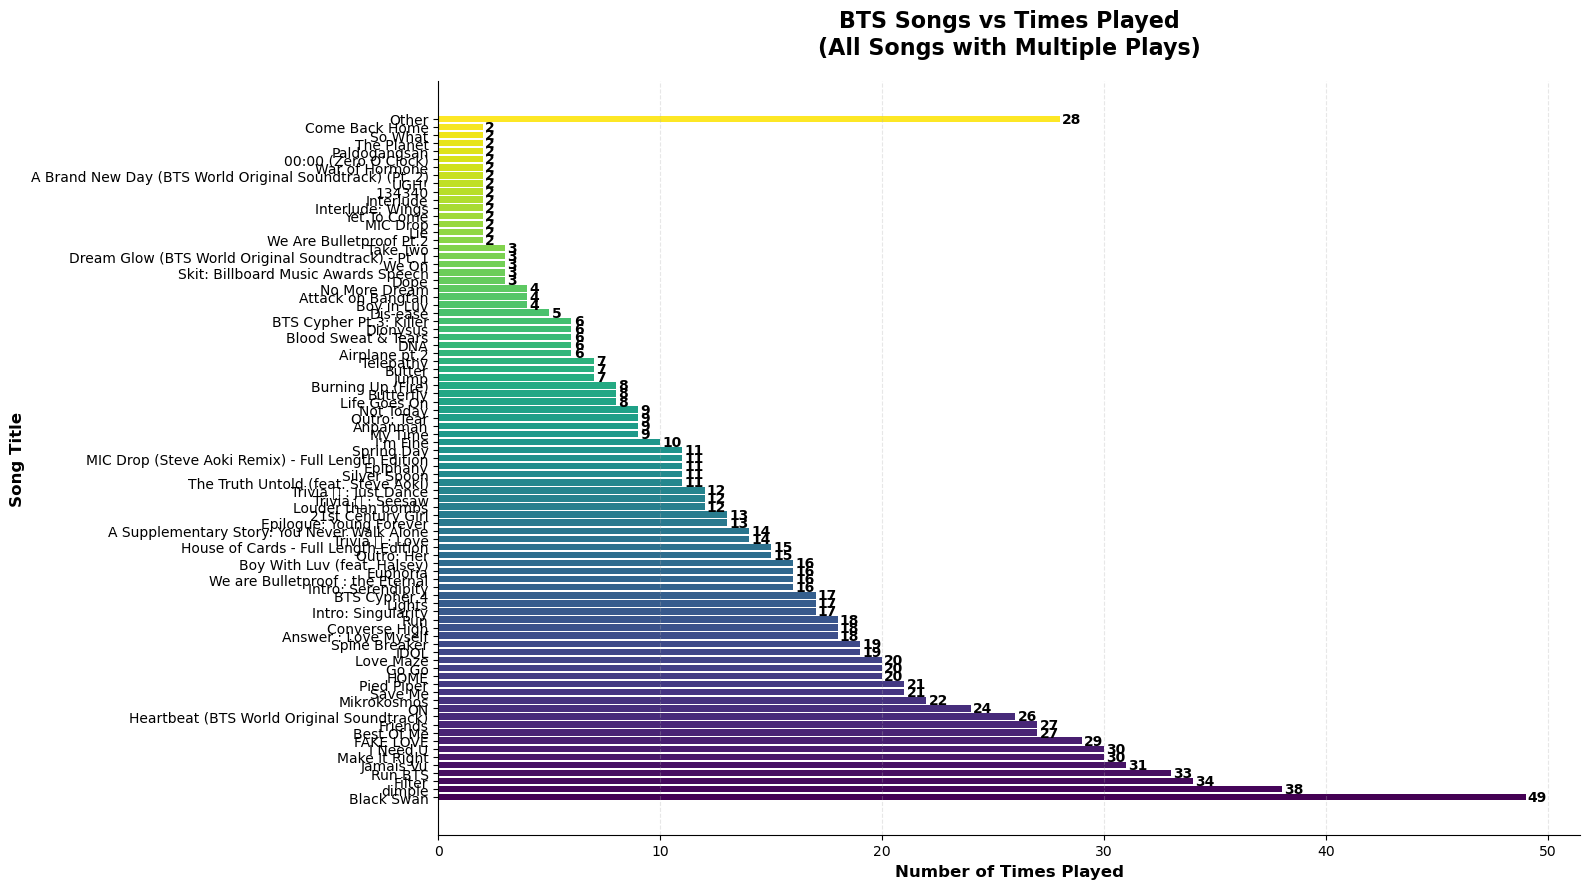

In [146]:
# Create improved horizontal bar chart for BTS songs
fig, ax = plt.subplots(figsize=(16, 9))

# Create color gradient based on play count
colors = plt.cm.viridis(np.linspace(0, 1, len(plays)))

bars = ax.barh(tracks, plays, color=colors)

# Customize the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, plays)):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{int(value)}', ha='left', va='center', fontweight='bold')

ax.set_xlabel('Number of Times Played', fontsize=12, fontweight='bold')
ax.set_ylabel('Song Title', fontsize=12, fontweight='bold')
ax.set_title('BTS Songs vs Times Played\n(All Songs with Multiple Plays)', 
             fontsize=16, fontweight='bold', pad=20)

# Improve tick formatting
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)

# Add grid for better readability
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

Once again the information is difficult to decipher so let's just focus on my top 20 BTS songs. From this we can determine which BTS song was my favorite in the last year. <br> To do so we can use the information from song_counts but specifically take out the first 20 rows. 

In [147]:
top_20_BTS = song_counts
top_20_BTS = song_counts.take(np.arange(0, 20))
top_20_BTS

,trackName,timesPlayed
0,Black Swan,49
1,dimple,38
2,Filter,34
3,Run BTS,33
4,Jamais Vu,31
5,Make It Right,30
6,I Need U,30
7,FAKE LOVE,29
8,Best Of Me,27
9,Friends,27


Now we can try plotting out these top 20 songs in a pie chart and see the distribution of my favorite songs. 

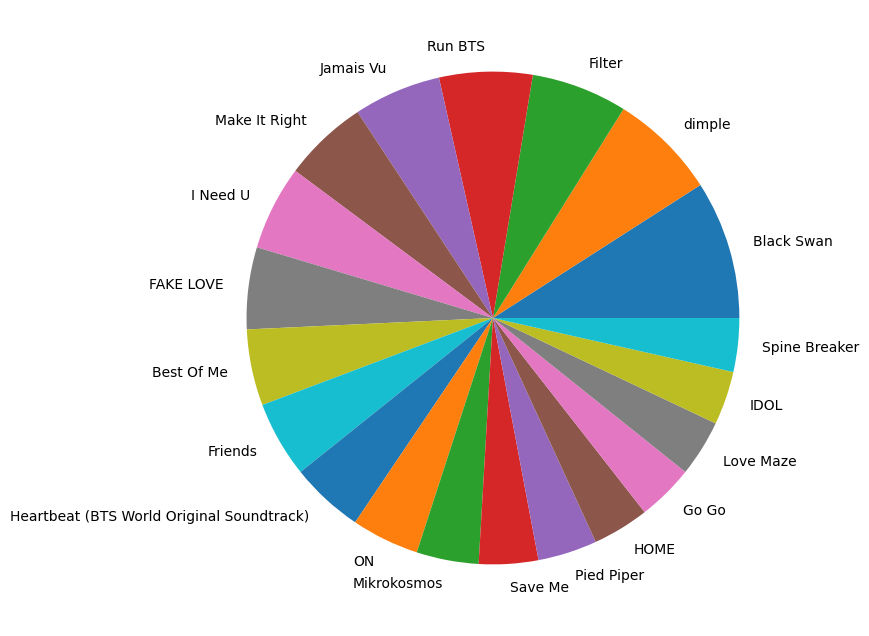

In [148]:
plt.pie(top_20_BTS['timesPlayed'], labels = top_20_BTS['trackName'])
plt.show()

Though we have the pie chart above it is still a bit difficult to visually determine which song is my favorite so let us try using the bar chart again. 

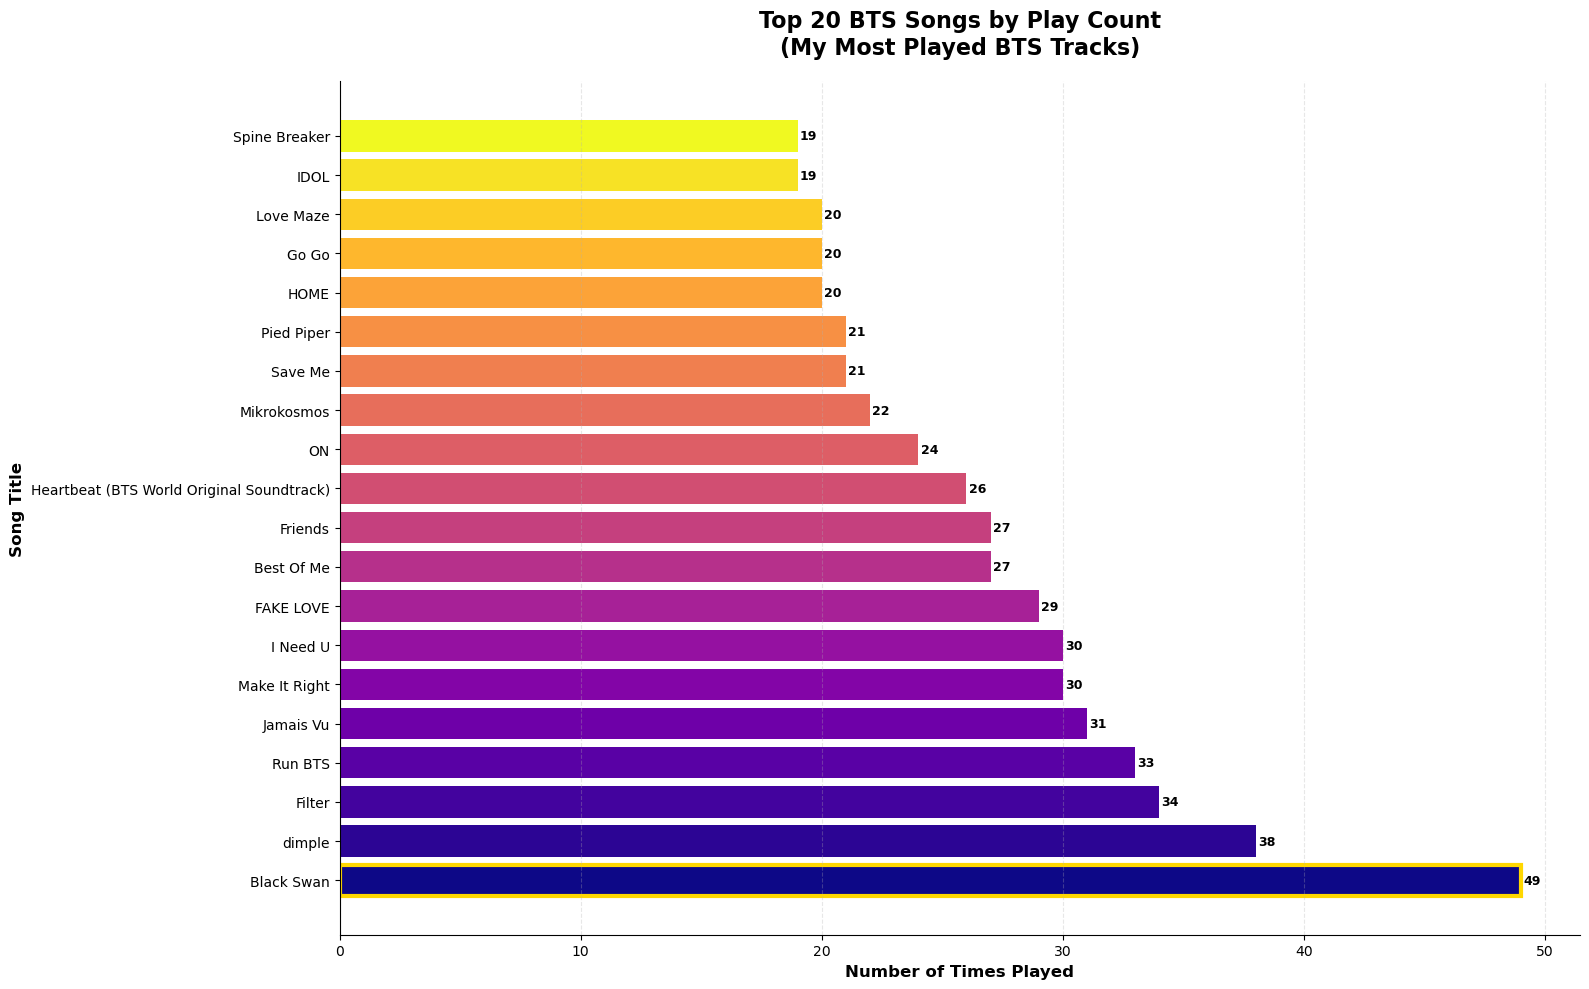

In [149]:

# Create enhanced visualization for top 20 BTS songs
fig, ax = plt.subplots(figsize=(16, 10))

# Create color gradient for top 20 songs
colors = plt.cm.plasma(np.linspace(0, 1, len(top_20_BTS)))

bars = ax.barh(top_20_BTS['trackName'], top_20_BTS['timesPlayed'], color=colors)

# Customize the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top_20_BTS['timesPlayed'])):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{int(value)}', ha='left', va='center', fontweight='bold', fontsize=9)

ax.set_xlabel('Number of Times Played', fontsize=12, fontweight='bold')
ax.set_ylabel('Song Title', fontsize=12, fontweight='bold')
ax.set_title('Top 20 BTS Songs by Play Count\n(My Most Played BTS Tracks)', 
             fontsize=16, fontweight='bold', pad=20)

# Improve tick formatting
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)

# Add grid for better readability
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Highlight the top song
if len(bars) > 0:
    bars[0].set_edgecolor('gold')
    bars[0].set_linewidth(3)

plt.tight_layout()
plt.show()

From this chart it's clear that my favorite BTS song was 'Black Swan'. This would make sense as this song is part of my studying playlist which I tend to use quite often. Looking through all of the song names I notice that they come from many different albums which made me curious to see how frequently I listen to songs from various albums. 
In order to determine this I believe the best approach is to create a function that will determine which album the song comes from and save that value into a new column in the data frame 'bts'. The best way to do this will be to define a function and apply it to the track names. 

In [150]:
#I'm curious to see if we can figure out which album is my favorite
#I think I can start by making lists of all the albums and their songs 
#a dictionary might help here where the keys are album names and the values are lists of song titles 
#and then write a function to determine which album each song is 
#apply that function to the track name and then create a new column of just album 

In [151]:
#BACK LOG OF UNUSED CODE
# def pie_chart_lists(dataframe):
#     output = []
#     track = []
#     #For the purposes of this function we're going to assume the dataframe is in the same format as song_counts
#     tracks = dataframe['trackName']
#     plays = dataframe['timesPlayed']
#     reps = dataframe.shape[0]
#     for i in range(reps): 

In [152]:
#This is where I will start using the method that was described in the medium article that janine sent me. 


In [153]:
import ast
from typing import List
from os import listdir
def get_streamings(path: str = 'Spotify Account Data') -> List[dict]:
    
    files = ['Spotify Account Data/' + x for x in listdir(path)
             if x.split('.')[0][:-1] == 'StreamingHistory']
    
    all_streamings = []
    
    for file in files: 
        with open(file, 'r', encoding='UTF-8') as f:
            new_streamings = ast.literal_eval(f.read())
            all_streamings += [streaming for streaming 
                               in new_streamings]
    return all_streamings

In [154]:

# Spotify API Setup (using environment variables for security)
%pip install spotipy
# Spotify API Setup using SpotifyOAuth (auto-refresh via token cache)
# Use shared auth helper for auto-refreshing Spotify tokens
from spotify_auth import get_spotify_client

spotify, token = get_spotify_client()
if token:
    print('Spotify authentication ready (token cached/auto-refreshed).')
else:
    print('Spotify authentication not available. Set env vars and re-run this cell.')

Note: you may need to restart the kernel to use updated packages.
Spotify authentication not available. Set env vars and re-run this cell.


In [155]:
import requests
from typing import Optional

def get_id(track_name: str, token: Optional[str], artist: Optional[str] = None) -> Optional[str]:
    """Return Spotify track ID for a given track name (and optional artist)."""
    if not token:
        return None
    headers = {
        'Accept': 'application/json',
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {token}',
    }
    query = track_name if not artist else f"track:{track_name} artist:{artist}"
    params = [
        ('q', query),
        ('type', 'track'),
        ('limit', 1),
    ]
    try:
        response = requests.get('https://api.spotify.com/v1/search', headers=headers, params=params, timeout=8)
        response.raise_for_status()
        js = response.json()
        items = js.get('tracks', {}).get('items', [])
        if items:
            return items[0].get('id')
        return None
    except Exception:
        return None

In [156]:
# Example usage guarded by token
if token:
    lucy_id = get_id('Lucy', token, artist='The Beatles')
    print(lucy_id)
else:
    print('Skipping get_id example (no Spotify token).')

Skipping get_id example (no Spotify token).


In [157]:
import spotipy 
from typing import Optional

def get_features(track_id: Optional[str], token: Optional[str]) -> Optional[dict]:
    if not token or not track_id:
        return None
    sp = spotipy.Spotify(auth=token)
    try:
        features = sp.audio_features([track_id])
        return features[0] if features and features[0] else None
    except Exception:
        return None

In [158]:
if 'lucy_id' in globals() and lucy_id and token:
    lucy_features = get_features(lucy_id, token)
    print(lucy_features)
else:
    print('Skipping get_features example (no token or track id).')

Skipping get_features example (no token or track id).


In [159]:
streamings = get_streamings()
unique_tracks = list(set([streaming['trackName'] for streaming in streamings]))

all_features = {}
if token:
    for track in unique_tracks:
        track_id = get_id(track, token)
        features = get_features(track_id, token)
        if features:
            all_features[track] = features
else:
    print('Skipping feature retrieval (no Spotify token).')

with_features = []
for track_name, features in all_features.items():
    with_features.append({'name': track_name, **features})

Skipping feature retrieval (no Spotify token).


In [160]:
# Use environment-configured credentials; token may be None
my_history = pd.DataFrame(with_features)
# df.to_csv('streaming_history.csv')
# my_history = pd.read_csv('streaming_history.csv')
my_history.columns

RangeIndex(start=0, stop=0, step=1)

In [161]:
from spotipy import Spotify

if token:
    spotify = Spotify(auth=token)
    all_of_bts_URI ='5GDuhKzwN0iBsa84eaxlkw'
    spotify_1 = spotify.playlist_tracks(all_of_bts_URI)
    playlist_tracks = spotify_1['items']
    spotify_1
else:
    print('Skipping playlist retrieval (no Spotify token).')
    playlist_tracks = []

Skipping playlist retrieval (no Spotify token).


In [162]:
import pandas as pd
song_df = pd.DataFrame({"URI": [],
                          "Album": [],
                          "Song Name": [],
                          "Artist": [],
                          "Disc Number": [],
                          "Track Number": [],
                          "Popularity": [],
                          "Explicit": [],
                          "Danceability": [],
                          "Energy": [],
                          "Key": [],
                          "Loudness": [],
                          "Mode": [],
                          "Speechiness": [],
                          "Acousticness": [],
                          "Instrumentalness": [],
                          "Liveness": [],
                          "Valence": [],
                          "Tempo": [],
                          "Duration_ms": [],
                          "Time Signature": []})



# idx = 0

# for hundred_songs in [spotify_1]:
#     for i, metadata in enumerate(hundred_songs["items"]):

#         uri = metadata["track"]["uri"].split(":")[2]
#         album = metadata["track"]["album"]["name"]
#         song_name = metadata["track"]["name"]
#         artists = metadata["track"]["artists"]
#         artists_string = ""
#         for artist in artists:
#             artists_string = artists_string + artist['name'] +"; "
#         artists_string = artists_string.strip("; ")

            
        
#         #Popularity of the track
#         track_pop = metadata["track"]["popularity"]
        
#         disc_number = metadata["track"]["disc_number"]
#         track_number = metadata["track"]["track_number"]
        
#         exp = metadata["track"]["explicit"]

#         song = sp.audio_features(uri)[0]
idx = 0
if token and playlist_tracks:
    for metadata in playlist_tracks:
        uri = metadata["track"]["uri"].split(":")[2]
        album = metadata["track"]["album"]["name"]
        song_name = metadata["track"]["name"]
        artists = metadata["track"]["artists"]
        artists_string = ""
        for artist in artists:
            artists_string = artists_string + artist['name'] + "; "
        artists_string = artists_string.strip("; ")

        # Popularity of the track
        track_pop = metadata["track"]["popularity"]

        disc_number = metadata["track"]["disc_number"]
        track_number = metadata["track"]["track_number"]

        exp = metadata["track"]["explicit"]

        # Use the correct Spotify object here
        song = spotify.audio_features(uri)[0]
        if not song:
            continue
        dan = song['danceability']
        ene = song['energy']
        key = song['key']
        lou = song['loudness']
        mod = song['mode']
        spe = song['speechiness']
        aco = song['acousticness']
        ins = song['instrumentalness']
        liv = song['liveness']
        val = song['valence']
        tem = song['tempo']
        dur = song['duration_ms']
        tim = song['time_signature']

        song_df.loc[idx] = [uri, album, song_name, artists_string, disc_number, track_number, track_pop, exp, 
                                   dan, ene, key, lou, mod, spe, aco,
                                   ins, liv, val, tem, dur, tim]
        idx += 1
else:
    print('Skipping audio features collection (no Spotify token).')

song_df.to_csv('all_BTS.csv', index=False)
song_df


Skipping audio features collection (no Spotify token).


,URI,Album,Song Name,Artist,Disc Number,Track Number,Popularity,Explicit,Danceability,Energy,...,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Time Signature


In [163]:
all_BTS_df = song_df

I have now successfully obtained a data frame that contains all the information about the top 84 BTS songs I listend to in the last year. <br> Note: Since the Spotify API gave me a 100 song limit on the number of songs I could use I am only considering their full-Korean albums to make more space. I also determined earlier that I listened to 112 different BTS songs which exceeds the limit given to me. So instead I have queried out songs that I only listened to once in the previous year. My reasoning was that since I only listened to the song one time they have little weight on what my favorite albums are. It is also likely that a fair number of these of these songs were only played one time because they automatically played after a different song that I was listening to. 

Now we can begin to analyze how my favorite songs compare to my favorite albums. 

In [164]:
mult_plays = song_counts[song_counts['timesPlayed'] != 1]
all_BTS_df

,URI,Album,Song Name,Artist,Disc Number,Track Number,Popularity,Explicit,Danceability,Energy,...,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Time Signature


First we group 'all_BTS_df' by the albums. I have reset the index to make sure that I can treat the 'Album' column as a series in the future. 

In [165]:
grouped_by_album = all_BTS_df.groupby('Album').count().reset_index()
grouped_by_album

,Album,URI,Song Name,Artist,Disc Number,Track Number,Popularity,Explicit,Danceability,Energy,...,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Time Signature


Since the count() aggregator just counts the number of matching instances per album we can just look one of these columns. In this case I'll use the URI column to do this and sort in descending order. 

In [166]:
sorted_grouped_by_album = grouped_by_album.sort_values('URI', ascending=False)[['Album', 'URI']]
sorted_grouped_by_album

,Album,URI


Now we can visualize this and compare it with our song information from before.

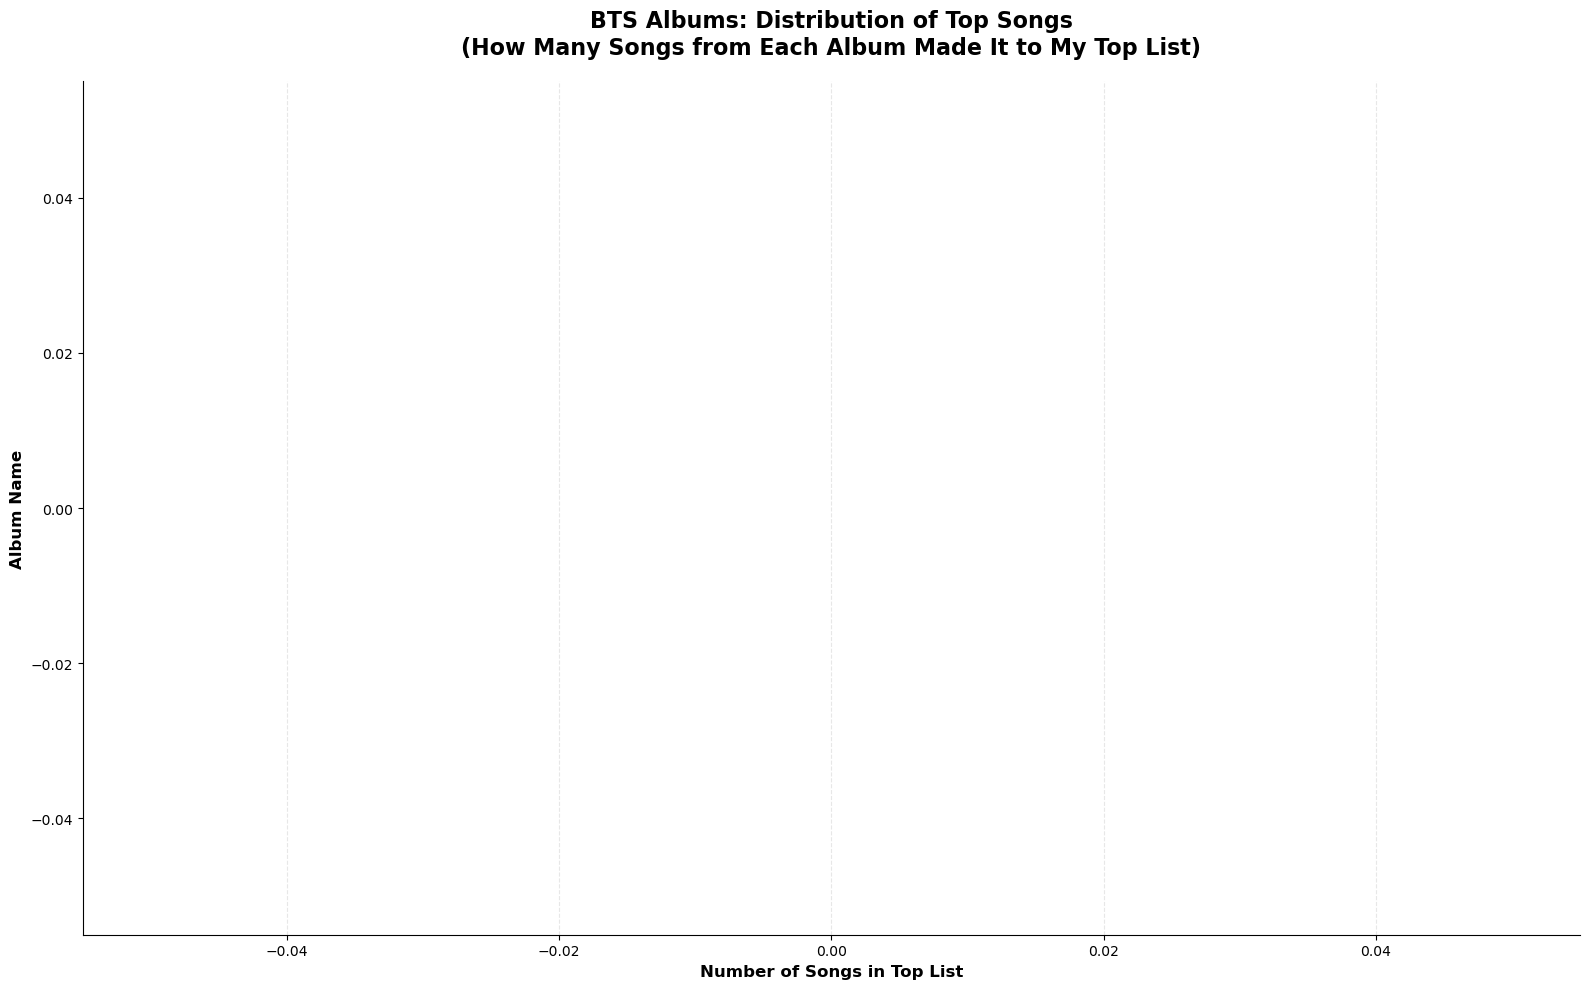

In [167]:
# Create enhanced album analysis visualization
albums = sorted_grouped_by_album['Album']
songs_per_album = sorted_grouped_by_album['URI'] 

fig, ax = plt.subplots(figsize=(16, 10))

# Create color gradient for albums
colors = plt.cm.Set3(np.linspace(0, 1, len(albums)))

bars = ax.barh(albums, songs_per_album, color=colors)

# Customize the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, songs_per_album)):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{int(value)}', ha='left', va='center', fontweight='bold')

ax.set_xlabel('Number of Songs in Top List', fontsize=12, fontweight='bold')
ax.set_ylabel('Album Name', fontsize=12, fontweight='bold')
ax.set_title('BTS Albums: Distribution of Top Songs\n(How Many Songs from Each Album Made It to My Top List)', 
             fontsize=16, fontweight='bold', pad=20)

# Improve tick formatting
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)

# Add grid for better readability
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

Based on this visualization we can see that four different albums have the same number of songs that appear in my top BTS songs. To truly determine which of these four albums is my favorite I'm going to create a new data frame called 'top_four_albums' which only contains songs from these albums. Then I will see how many songs in the top 10 of 'song_counts' appear in the corresponding albums. 

In [168]:
top_10_songs = song_counts.take(np.arange(0,10))
top_10_songs

,trackName,timesPlayed
0,Black Swan,49
1,dimple,38
2,Filter,34
3,Run BTS,33
4,Jamais Vu,31
5,Make It Right,30
6,I Need U,30
7,FAKE LOVE,29
8,Best Of Me,27
9,Friends,27


In [169]:
song_counts

,trackName,timesPlayed
0,Black Swan,49
1,dimple,38
2,Filter,34
3,Run BTS,33
4,Jamais Vu,31
...,...,...
107,Skit: R U Happy Now?,1
108,Skit: Circle Room Talk,1
109,Begin,1
110,Stay,1


In [170]:
# Select up to the top 4 albums safely
num = min(4, len(sorted_grouped_by_album))
top_four_album_names = sorted_grouped_by_album['Album'].head(num)
print(top_four_album_names)

top_four_albums = all_BTS_df[all_BTS_df['Album'].isin(top_four_album_names)]
top_four_albums 

Series([], Name: Album, dtype: float64)


,URI,Album,Song Name,Artist,Disc Number,Track Number,Popularity,Explicit,Danceability,Energy,...,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Time Signature


I'm now going to merge this with the 'top_four_albums' data frame with the 'song_counts' data frame. And then query out just the 'Album', 'Song Name', and 'Times Played' columns so we can get a better look of the relevant information. <br> Note: For consistency I also renamed the 'timesPlayed' column to 'Times Played'.

In [171]:
#i just want to see what happens if i merge this with top song counts on the song name column
merged = top_four_albums.merge(song_counts, left_on='Song Name', right_on = 'trackName')
merged = merged.assign(Times_Played = merged['timesPlayed'])
merged = merged.rename(columns={'Times_Played': 'Times Played'})
top_four_albums_w_counts = merged[['Album', 'Song Name', 'Times Played']].sort_values('Times Played', ascending = False)
top_four_albums_w_counts

,Album,Song Name,Times Played


Now let us try and see how many of my top 10 BTS songs came from which albums. First we take out the top 10 rows, I'll store them in a data frame called 'top_10'.

In [172]:
top_20 = top_four_albums_w_counts.head(20)
top_20

,Album,Song Name,Times Played


Now we group by the album and the song names to organize everything into these groups. 

In [173]:
grouped_top_20 = top_20.groupby(['Album', 'Song Name']).max()
grouped_top_20 

,,Times Played
Album,Song Name,


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


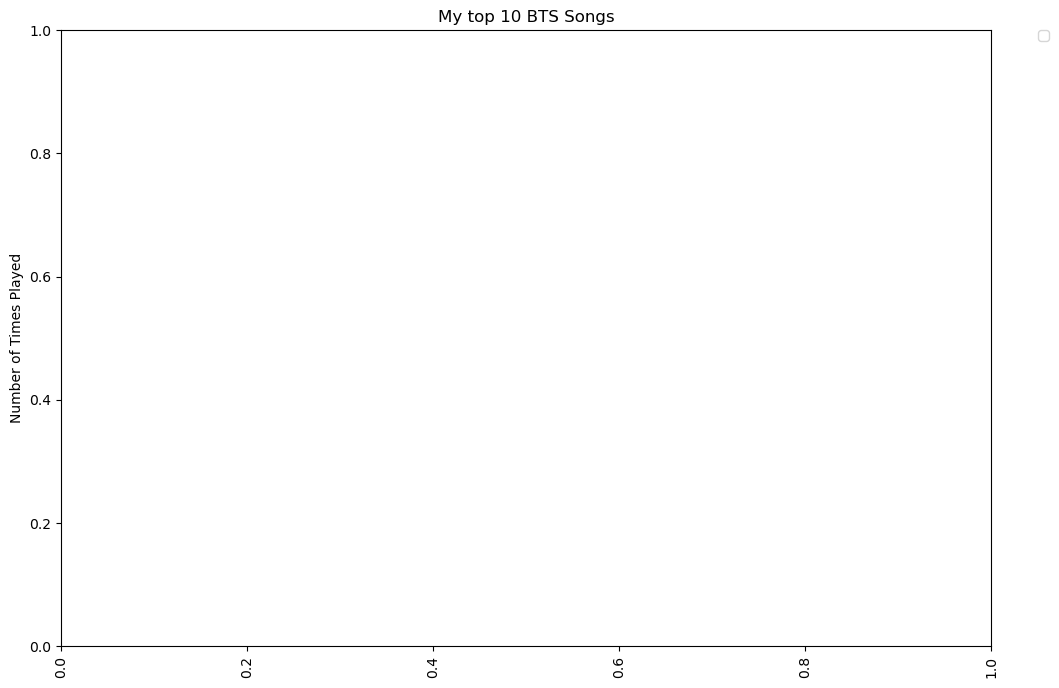

In [174]:
import seaborn as sns
grouped_top_20_reset_index  = grouped_top_20.reset_index()

# Sort the DataFrame by 'Times Played' in descending order
grouped_top_20_reset_index_sorted = grouped_top_20_reset_index.sort_values(by='Times Played', ascending=False)

# Plot the barplot with the sorted DataFrame
ax = sns.barplot(x='Song Name', y='Times Played', data=grouped_top_20_reset_index_sorted, hue='Album', dodge=False)

plt.title("My top 10 BTS Songs")
plt.xticks(rotation=90)
plt.ylabel("Number of Times Played")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

And from this I can determine that many of my top songs come from the album "MAP OF THE SOUL: 7". This also implies that this album has been my favorite out of the BTS discography for the past year.

## My Extended Wrapped History <br>

As of December 15th, 2023 I now have access to my extended listening history which goes as far back as my first day of using spotify in 2018. Let's dive in to this data and see what we can learn about how my music tastes have changed over the past few years!

For consistency let us first begin by importing all the necessary packages again. This may be a bit redundant but it's faster than having to scroll all the way back up again. 

In [175]:
import json
import csv
import pandas as pd
try:
    import babypandas as bpd
except Exception:
    bpd = pd
import numpy as np
import matplotlib.pyplot as plt

Now we go through the process of converting each json file into pandas data frames. Though it would be possible for me turn everything into a single data frame in one step I'm making separate data frames in case there comes a time where I want to look at specific years. 

In [176]:
yrs_2018_2020 = pd.read_json('Spotify Extended Streaming History/Streaming_History_Audio_2018-2020_0.json')
yrs_2018_2020 = yrs_2018_2020.drop(['platform', 
                                    'username', 
                                    'ip_addr_decrypted', 
                                    'user_agent_decrypted', 
                                    'offline_timestamp', 
                                    'incognito_mode',
                                    'offline'], axis =1)
yrs_2018_2020


,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped
0,2018-04-17T01:11:53Z,3250,US,Power,EXO,THE POWER OF MUSIC – The 4th Album ‘THE WAR’ R...,spotify:track:53YZi9zgTnF0Py0K6ejyWz,None,None,None,clickrow,fwdbtn,False,NaN
1,2018-04-17T01:11:59Z,5503,US,Me Like Yuh,Jay Park,Everything You Wanted,spotify:track:5S5gGOsUarzRXKoaSstwba,None,None,None,fwdbtn,fwdbtn,False,NaN
2,2018-04-17T01:12:08Z,8962,US,RUMOR,KARD,"K.A.R.D Project Vol.3 ""RUMOR""",spotify:track:22iz04Hw1tz0NBpiyoEMT1,None,None,None,fwdbtn,endplay,False,NaN
3,2018-04-17T01:12:12Z,3854,US,MIC Drop,BTS,Love Yourself 承 'Her',spotify:track:2SYa5Lx1uoCvyDIW4oee9b,None,None,None,clickrow,endplay,False,NaN
4,2018-04-17T01:12:31Z,3088,US,DNA,BTS,Love Yourself 承 'Her',spotify:track:5SE57ljOIUJ1ybL9U6CuBH,None,None,None,clickrow,endplay,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16149,2020-02-05T05:20:54Z,247733,US,Farewell,Eminem,Music To Be Murdered By,spotify:track:74gykWHknHDrg4eMdcmdRq,None,None,None,clickrow,trackdone,False,NaN
16150,2020-02-05T05:21:16Z,20928,US,No Regrets (feat. Don Toliver),Eminem,Music To Be Murdered By,spotify:track:1lO9CZo6eDrOy0S7khgryG,None,None,None,trackdone,endplay,False,NaN
16151,2020-02-05T05:24:13Z,177693,US,Those Kinda Nights (feat. Ed Sheeran),Eminem,Music To Be Murdered By,spotify:track:0VSzREd1OjEWJ9tXoFHRQH,None,None,None,clickrow,trackdone,False,NaN
16152,2020-02-05T05:24:48Z,22328,US,In Too Deep,Eminem,Music To Be Murdered By,spotify:track:7Dj2wqPYXfSRFwa6qyOztr,None,None,None,trackdone,endplay,False,NaN


In [177]:
yrs_2020_2021 = pd.read_json('Spotify Extended Streaming History/Streaming_History_Audio_2020-2021_1.json')
yrs_2020_2021 = yrs_2020_2021.drop(['platform', 
                                    'username', 
                                    'ip_addr_decrypted', 
                                    'user_agent_decrypted', 
                                    'offline_timestamp', 
                                    'incognito_mode',
                                    'offline'], axis =1)
yrs_2020_2021

,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped
0,2020-02-05T15:14:17Z,1555,US,None,None,None,None,Ep. 76 - Deathly Hallows Ch. 25 w/ Matt Young,Potterless,spotify:episode:5aY37AWDiqKHLpsQyGWUoD,clickrow,endplay,False,NaN
1,2020-02-05T17:24:26Z,750207,US,None,None,None,None,Ep. 77 - Deathly Hallows Ch. 26 w/ Matt Young,Potterless,spotify:episode:46rjpx5m3y2pH2AwoG3zUv,clickrow,logout,False,NaN
2,2020-02-05T19:30:21Z,228612,US,Outro: Her,BTS,Love Yourself 承 'Her',spotify:track:3l8yQMdniG6Os8gUBNXV57,None,None,None,fwdbtn,trackdone,True,NaN
3,2020-02-05T19:30:21Z,171023,US,Intro : Persona,BTS,MAP OF THE SOUL : PERSONA,spotify:track:2isSdmQfVv32j2haL6hk9x,None,None,None,trackdone,trackdone,True,NaN
4,2020-02-05T19:30:21Z,0,US,Anpanman,BTS,Love Yourself 結 'Answer',spotify:track:01gUlvzAPiwB9Ekq9kGVCM,None,None,None,trackdone,logout,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16298,2021-10-09T05:49:43Z,185277,US,X (with KAROL G),Jonas Brothers,XV,spotify:track:77fvnWALKJR0ws1VUx09CY,None,None,None,trackdone,trackdone,False,NaN
16299,2021-10-09T05:52:48Z,185277,US,X (with KAROL G),Jonas Brothers,XV,spotify:track:77fvnWALKJR0ws1VUx09CY,None,None,None,trackdone,trackdone,False,NaN
16300,2021-10-09T05:55:54Z,185277,US,X (with KAROL G),Jonas Brothers,XV,spotify:track:77fvnWALKJR0ws1VUx09CY,None,None,None,trackdone,trackdone,False,NaN
16301,2021-10-09T15:59:49Z,181771,US,X (with KAROL G),Jonas Brothers,XV,spotify:track:77fvnWALKJR0ws1VUx09CY,None,None,None,trackdone,logout,False,NaN


In [178]:
yrs_2021_2022 = pd.read_json('Spotify Extended Streaming History/Streaming_History_Audio_2021-2022_2.json')
yrs_2021_2022 = yrs_2021_2022.drop(['platform', 
                                    'username', 
                                    'ip_addr_decrypted', 
                                    'user_agent_decrypted', 
                                    'offline_timestamp', 
                                    'incognito_mode',
                                    'offline'], axis =1)
yrs_2021_2022

,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped
0,2021-10-09T16:03:07Z,185277,US,X (with KAROL G),Jonas Brothers,XV,spotify:track:77fvnWALKJR0ws1VUx09CY,None,None,None,trackdone,trackdone,False,NaN
1,2021-10-09T19:08:29Z,24370,US,X (with KAROL G),Jonas Brothers,XV,spotify:track:77fvnWALKJR0ws1VUx09CY,None,None,None,trackdone,logout,False,NaN
2,2021-10-09T19:13:09Z,256842,US,Love Again,Dua Lipa,Future Nostalgia,spotify:track:5CSKbHjpqborGnlzagyaDo,None,None,None,clickrow,endplay,False,NaN
3,2021-10-09T19:17:09Z,216053,US,Lonely (feat. ISÁK & Omar Noir),Alan Walker,Different World,spotify:track:6HMT7AzGA5wmn5m2t1BuZR,None,None,None,appload,trackdone,False,NaN
4,2021-10-09T19:20:38Z,208260,US,Let's Shut Up & Dance,Jason Derulo,Let's Shut Up & Dance,spotify:track:05fVrhFBjfElZiDfHDRxhF,None,None,None,trackdone,trackdone,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16074,2022-10-18T01:22:31Z,254653,US,Raanjhanaa,A.R. Rahman,Raanjhanaa (Original Motion Picture Soundtrack),spotify:track:5OMUXgfXsSukZ0zxelpC3b,None,None,None,fwdbtn,trackdone,False,0.0
16075,2022-10-18T01:25:23Z,170342,US,"Main Tera Boyfriend (From ""Raabta"")",Arijit Singh,Groove With Arijit Singh,spotify:track:5VAkPCJTE6tbyReo9J4IQj,None,None,None,trackdone,endplay,False,1.0
16076,2022-10-18T01:30:03Z,280369,US,Lat Lag Gayee,Benny Dayal,Race 2,spotify:track:5XsoDbDt98b0FkFLOhsJuS,None,None,None,clickrow,trackdone,False,0.0
16077,2022-10-18T01:34:00Z,237463,US,Shaam Shaandaar,Amit Trivedi,Shaandaar,spotify:track:46mXuHxCjDiLoLPsqn24P8,None,None,None,trackdone,trackdone,False,0.0


In [179]:
yrs_2022_2023 = pd.read_json('Spotify Extended Streaming History/Streaming_History_Audio_2022-2023_3.json')
yrs_2022_2023 = yrs_2022_2023.drop(['platform', 
                                    'username', 
                                    'ip_addr_decrypted', 
                                    'user_agent_decrypted', 
                                    'offline_timestamp', 
                                    'incognito_mode', 
                                    'offline'], axis =1)
yrs_2022_2023

,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped
0,2022-10-18T01:40:06Z,238994,US,Sau Tarah Ke,Pritam,Dishoom,spotify:track:54SQet8YMttOgTqDNGcGpe,None,None,None,clickrow,trackdone,False,False
1,2022-10-18T01:43:58Z,230557,US,"Jai Jai Shivshankar (From ""War"")",Vishal-Shekhar,YRF Top 10 - Nightout Sounds,spotify:track:1F3mmE11euAAjwPHCSwSCC,None,None,None,trackdone,trackdone,False,False
2,2022-10-18T01:48:41Z,282012,US,"Tum Hi Ho Bandhu (From ""Cocktail"")",Neeraj Shridhar,Cocktail,spotify:track:2zZTXtLqCsICzEcztKjn47,None,None,None,trackdone,trackdone,False,False
3,2022-10-18T03:17:38Z,164520,US,Where No One Goes,Jónsi,How To Train Your Dragon 2 (Music From The Mot...,spotify:track:47OTksldOYCxAJ7aH3zaxx,None,None,None,trackdone,trackdone,True,False
4,2022-10-18T03:21:13Z,213666,US,"Chopin: Nocturne No. 20 in C-Sharp Minor, Op. ...",Frédéric Chopin,Chopin: Nocturnes,spotify:track:6Yr6Zexsq4VUaDXy5GS9aF,None,None,None,trackdone,trackdone,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15954,2023-12-07T21:38:57Z,167989,US,motive (with Doja Cat),Ariana Grande,Positions,spotify:track:5GkQIP5mWPi4KZLLXeuFTT,None,None,None,clickrow,trackdone,False,False
15955,2023-12-07T21:39:08Z,9440,US,Señorita,Shawn Mendes,Shawn Mendes,spotify:track:6v3KW9xbzN5yKLt9YKDYA2,None,None,None,trackdone,endplay,False,True
15956,2023-12-07T21:42:14Z,185917,US,Houdini,Dua Lipa,Houdini,spotify:track:4OMJGnvZfDvsePyCwRGO7X,None,None,None,clickrow,trackdone,False,False
15957,2023-12-07T21:42:18Z,55,US,Sweet Melody,Little Mix,Confetti,spotify:track:76Tuo484SLohJakHLnGI3B,None,None,None,trackdone,logout,False,False


With all of these different data frames we can now combine them into one large data frame containing my entire listerning history on Spotify. 

In [180]:
all_years_ls = [yrs_2018_2020, yrs_2020_2021, yrs_2021_2022, yrs_2022_2023]
full_history = pd.concat(all_years_ls)
full_history

,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped
0,2018-04-17T01:11:53Z,3250,US,Power,EXO,THE POWER OF MUSIC – The 4th Album ‘THE WAR’ R...,spotify:track:53YZi9zgTnF0Py0K6ejyWz,None,None,None,clickrow,fwdbtn,False,NaN
1,2018-04-17T01:11:59Z,5503,US,Me Like Yuh,Jay Park,Everything You Wanted,spotify:track:5S5gGOsUarzRXKoaSstwba,None,None,None,fwdbtn,fwdbtn,False,NaN
2,2018-04-17T01:12:08Z,8962,US,RUMOR,KARD,"K.A.R.D Project Vol.3 ""RUMOR""",spotify:track:22iz04Hw1tz0NBpiyoEMT1,None,None,None,fwdbtn,endplay,False,NaN
3,2018-04-17T01:12:12Z,3854,US,MIC Drop,BTS,Love Yourself 承 'Her',spotify:track:2SYa5Lx1uoCvyDIW4oee9b,None,None,None,clickrow,endplay,False,NaN
4,2018-04-17T01:12:31Z,3088,US,DNA,BTS,Love Yourself 承 'Her',spotify:track:5SE57ljOIUJ1ybL9U6CuBH,None,None,None,clickrow,endplay,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15954,2023-12-07T21:38:57Z,167989,US,motive (with Doja Cat),Ariana Grande,Positions,spotify:track:5GkQIP5mWPi4KZLLXeuFTT,None,None,None,clickrow,trackdone,False,False
15955,2023-12-07T21:39:08Z,9440,US,Señorita,Shawn Mendes,Shawn Mendes,spotify:track:6v3KW9xbzN5yKLt9YKDYA2,None,None,None,trackdone,endplay,False,True
15956,2023-12-07T21:42:14Z,185917,US,Houdini,Dua Lipa,Houdini,spotify:track:4OMJGnvZfDvsePyCwRGO7X,None,None,None,clickrow,trackdone,False,False
15957,2023-12-07T21:42:18Z,55,US,Sweet Melody,Little Mix,Confetti,spotify:track:76Tuo484SLohJakHLnGI3B,None,None,None,trackdone,logout,False,False


My first question is how long have I spent using Spotify in the last few years so I'll use the 'ms_played' column to determine that. I'm going to go the nearest hour. <br> Something I have notied is that for each song I listen to it also tracks how much of that song I listened to. For example at the bottom of the data frame I noticed that one song has a value of only 55 'ms_played' which would indicate that I listened to that song for only a few seconds before skipping it. 

In [181]:
millisecs = full_history['ms_played'].sum()
seconds = millisecs / 1000
minutes = seconds / 60
hours = minutes / 60
print('I have spent ' + str(hours) + ' hours using Spotify since 2018.')

I have spent 2822.030202222222 hours using Spotify since 2018.


This number is difficult to conceptualize so let's try converting the number of hours into the number of days. 

In [182]:
days = hours / 24
print('I have spent about ' + str(int(np.round(days))) + ' whole days using Spotify.')
print('This is equivalent to spending about ' + str(np.round(((days/365)*100), 2)) + '% of a year listening to music non-stop.')

I have spent about 118 whole days using Spotify.
This is equivalent to spending about 32.21% of a year listening to music non-stop.


The next thing that I notice is that some of these rows contain information that would indicate it is a podcast episode rather than a song. Let us split this data frame into 'all_music' and 'all_podcast_eps'. 

In [183]:
full_history['episode_show_name'] = full_history['episode_show_name'].astype(str)
all_music = full_history[full_history['episode_show_name'] == 'None']
all_podcast_eps = full_history[full_history['episode_show_name'] != 'None']
all_music

,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped
0,2018-04-17T01:11:53Z,3250,US,Power,EXO,THE POWER OF MUSIC – The 4th Album ‘THE WAR’ R...,spotify:track:53YZi9zgTnF0Py0K6ejyWz,None,None,None,clickrow,fwdbtn,False,NaN
1,2018-04-17T01:11:59Z,5503,US,Me Like Yuh,Jay Park,Everything You Wanted,spotify:track:5S5gGOsUarzRXKoaSstwba,None,None,None,fwdbtn,fwdbtn,False,NaN
2,2018-04-17T01:12:08Z,8962,US,RUMOR,KARD,"K.A.R.D Project Vol.3 ""RUMOR""",spotify:track:22iz04Hw1tz0NBpiyoEMT1,None,None,None,fwdbtn,endplay,False,NaN
3,2018-04-17T01:12:12Z,3854,US,MIC Drop,BTS,Love Yourself 承 'Her',spotify:track:2SYa5Lx1uoCvyDIW4oee9b,None,None,None,clickrow,endplay,False,NaN
4,2018-04-17T01:12:31Z,3088,US,DNA,BTS,Love Yourself 承 'Her',spotify:track:5SE57ljOIUJ1ybL9U6CuBH,None,None,None,clickrow,endplay,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15954,2023-12-07T21:38:57Z,167989,US,motive (with Doja Cat),Ariana Grande,Positions,spotify:track:5GkQIP5mWPi4KZLLXeuFTT,None,None,None,clickrow,trackdone,False,False
15955,2023-12-07T21:39:08Z,9440,US,Señorita,Shawn Mendes,Shawn Mendes,spotify:track:6v3KW9xbzN5yKLt9YKDYA2,None,None,None,trackdone,endplay,False,True
15956,2023-12-07T21:42:14Z,185917,US,Houdini,Dua Lipa,Houdini,spotify:track:4OMJGnvZfDvsePyCwRGO7X,None,None,None,clickrow,trackdone,False,False
15957,2023-12-07T21:42:18Z,55,US,Sweet Melody,Little Mix,Confetti,spotify:track:76Tuo484SLohJakHLnGI3B,None,None,None,trackdone,logout,False,False


In [184]:
all_podcast_eps

,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped
10560,2019-06-23T16:19:29Z,28252,US,None,None,None,None,Day Two of Trump's U.K. Visit & Why Young Amer...,The Daily Show: Ears Edition,spotify:episode:7HZnNecKoxtLpqyGjfR7qQ,clickrow,logout,False,NaN
12010,2019-09-15T18:18:17Z,792160,US,None,None,None,None,Ep. 0 - Everything I Know Before Reading the B...,Potterless,spotify:episode:6x8HxhJIjCjOnFwDzQtkQh,clickrow,trackdone,False,NaN
12011,2019-09-15T19:41:21Z,3000480,US,None,None,None,None,Ep. 1 - Sorcerer's Stone Ch. 1-8 w/ Alex Moothart,Potterless,spotify:episode:6axizYtyx8IPXa0ZvjHyjC,trackdone,trackdone,False,NaN
12012,2019-09-15T22:30:11Z,1622238,US,None,None,None,None,Ep. 2 - Sorcerer's Stone Ch. 9-17 w/ Charlotte...,Potterless,spotify:episode:7ec2WEzLzBpcbxGZcQ6Wku,trackdone,endplay,False,NaN
12045,2019-09-16T00:40:02Z,2180454,US,None,None,None,None,Ep. 2 - Sorcerer's Stone Ch. 9-17 w/ Charlotte...,Potterless,spotify:episode:7ec2WEzLzBpcbxGZcQ6Wku,clickrow,trackdone,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7371,2023-05-16T15:28:57Z,150,US,None,None,None,None,Transportation,Distractible,spotify:episode:0khBLR15TmXtfzwhePbn70,trackdone,trackdone,False,False
7372,2023-05-16T15:29:24Z,24296,US,None,None,None,None,Camping,Distractible,spotify:episode:4s423Ody378ElbZq84ib7o,trackdone,endplay,False,True
7409,2023-05-17T19:19:37Z,273147,US,None,None,None,None,Fake Tech,Distractible,spotify:episode:05Mx3DX8Ji1gIlY4Yt6BnO,clickrow,endplay,False,True
7578,2023-05-23T00:32:15Z,231176,US,None,None,None,None,Fake Tech,Distractible,spotify:episode:05Mx3DX8Ji1gIlY4Yt6BnO,clickrow,trackdone,False,False


From here we can adjust each data frame to only include the relavant columns for each type of media. For example we can remove columns for the episode name in 'all_songs' and we can remove information pertaining to artist and track names in 'all_podcast_eps'. 

In [185]:
all_music.columns

Index(['ts', 'ms_played', 'conn_country', 'master_metadata_track_name',
       'master_metadata_album_artist_name', 'master_metadata_album_album_name',
       'spotify_track_uri', 'episode_name', 'episode_show_name',
       'spotify_episode_uri', 'reason_start', 'reason_end', 'shuffle',
       'skipped'],
      dtype='object')

I notice that the columns do not appear to exist even though I can physically see them in the data frame. So I need to start poking around ot see what is causing this issue. 

In [186]:
all_music
print(all_music['episode_name'])
print(all_music['episode_show_name'])
print(all_music['spotify_episode_uri'])
print(all_music.head())

0        None
1        None
2        None
3        None
4        None
         ... 
15954    None
15955    None
15956    None
15957    None
15958    None
Name: episode_name, Length: 63670, dtype: object
0        None
1        None
2        None
3        None
4        None
         ... 
15954    None
15955    None
15956    None
15957    None
15958    None
Name: episode_show_name, Length: 63670, dtype: object
0        None
1        None
2        None
3        None
4        None
         ... 
15954    None
15955    None
15956    None
15957    None
15958    None
Name: spotify_episode_uri, Length: 63670, dtype: object
                     ts  ms_played conn_country master_metadata_track_name  \
0  2018-04-17T01:11:53Z       3250           US                      Power   
1  2018-04-17T01:11:59Z       5503           US                Me Like Yuh   
2  2018-04-17T01:12:08Z       8962           US                      RUMOR   
3  2018-04-17T01:12:12Z       3854           US                   M

When I print out the data frame info I notice that almost every column is in the form of an object which is most likely the issue. <br>
 So before we can drop these columns we need to convert them to a strings. For the time being I'm only going to do this for the columns I intend to drop. 

In [187]:
print(all_music.info())

<class 'pandas.core.frame.DataFrame'>
Index: 63670 entries, 0 to 15958
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   ts                                 63670 non-null  object
 1   ms_played                          63670 non-null  int64 
 2   conn_country                       63670 non-null  object
 3   master_metadata_track_name         63592 non-null  object
 4   master_metadata_album_artist_name  63592 non-null  object
 5   master_metadata_album_album_name   63592 non-null  object
 6   spotify_track_uri                  63592 non-null  object
 7   episode_name                       0 non-null      object
 8   episode_show_name                  63670 non-null  object
 9   spotify_episode_uri                0 non-null      object
 10  reason_start                       63670 non-null  object
 11  reason_end                         63670 non-null  object
 12  shuffle  

In [188]:
columns_to_convert = ['episode_name', 'episode_show_name', 'spotify_episode_uri']
all_music[columns_to_convert] = all_music[columns_to_convert].astype(str)

In [189]:
all_music = all_music.drop(['episode_name', 
                            'episode_show_name', 
                            'spotify_episode_uri'], axis=1)

# Data Quality Assessment
def assess_data_quality(df, name="Dataset"):
    """Comprehensive data quality assessment"""
    print(f"\n=== {name} Data Quality Assessment ===")
    print(f"Shape: {df.shape}")
    print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print("\nMissing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': missing_pct
    }).sort_values('Missing %', ascending=False)
    print(missing_df[missing_df['Missing Count'] > 0])
    
    print("\nData Types:")
    print(df.dtypes.value_counts())
    
    print("\nNumeric Columns Summary:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(df[numeric_cols].describe())
    
    return df

# Assess data quality
all_music = assess_data_quality(all_music, "Music Streaming Data")


=== Music Streaming Data Data Quality Assessment ===
Shape: (63670, 11)
Memory Usage: 34.30 MB

Missing Values:
                                   Missing Count  Missing %
skipped                                    47477  74.567300
master_metadata_track_name                    78   0.122507
master_metadata_album_album_name              78   0.122507
spotify_track_uri                             78   0.122507
master_metadata_album_artist_name             78   0.122507

Data Types:
object    9
int64     1
bool      1
Name: count, dtype: int64

Numeric Columns Summary:
           ms_played
count   63670.000000
mean   149091.521187
std     90110.670038
min         0.000000
25%     52952.000000
50%    182079.000000
75%    214548.500000
max    737072.000000


Now that I have separated my music history from my podcast history I am able to do more individual analysis on each. <br>
In order to do analysis on each year let us create a new column called year and transform the time stamp column.

In [190]:
# Convert timestamps to proper datetime objects and extract time-based features
def process_timestamps(df):
    """Process timestamp column to extract various time-based features"""
    # Convert to datetime
    df['datetime'] = pd.to_datetime(df['ts'])
    
    # Extract time-based features
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day_of_week'] = df['datetime'].dt.day_name()
    df['hour'] = df['datetime'].dt.hour
    df['date'] = df['datetime'].dt.date
    
    # Create time of day categories
    def categorize_time_of_day(hour):
        if 6 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 22:
            return 'Evening'
        else:
            return 'Night'
    
    df['time_of_day'] = df['hour'].apply(categorize_time_of_day)
    
    # Create season based on month
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'
    
    df['season'] = df['month'].apply(get_season)
    
    return df

# Process timestamps for all_music
all_music = process_timestamps(all_music)

# Reorder columns to put time features at the front
time_columns = ['year', 'month', 'day_of_week', 'hour', 'time_of_day', 'season', 'date']
other_columns = [col for col in all_music.columns if col not in time_columns and col != 'datetime']
all_music = all_music[time_columns + other_columns]

print("Timestamp processing complete. Added time-based features:")
print(f"- Years: {sorted(all_music['year'].unique())}")
print(f"- Time of day categories: {sorted(all_music['time_of_day'].unique())}")
print(f"- Seasons: {sorted(all_music['season'].unique())}")
all_music.head()

Timestamp processing complete. Added time-based features:
- Years: [2018, 2019, 2020, 2021, 2022, 2023]
- Time of day categories: ['Afternoon', 'Evening', 'Morning', 'Night']
- Seasons: ['Fall', 'Spring', 'Summer', 'Winter']


,year,month,day_of_week,hour,time_of_day,season,date,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,reason_start,reason_end,shuffle,skipped
0,2018,4,Tuesday,1,Night,Spring,2018-04-17,2018-04-17T01:11:53Z,3250,US,Power,EXO,THE POWER OF MUSIC – The 4th Album ‘THE WAR’ R...,spotify:track:53YZi9zgTnF0Py0K6ejyWz,clickrow,fwdbtn,False,NaN
1,2018,4,Tuesday,1,Night,Spring,2018-04-17,2018-04-17T01:11:59Z,5503,US,Me Like Yuh,Jay Park,Everything You Wanted,spotify:track:5S5gGOsUarzRXKoaSstwba,fwdbtn,fwdbtn,False,NaN
2,2018,4,Tuesday,1,Night,Spring,2018-04-17,2018-04-17T01:12:08Z,8962,US,RUMOR,KARD,"K.A.R.D Project Vol.3 ""RUMOR""",spotify:track:22iz04Hw1tz0NBpiyoEMT1,fwdbtn,endplay,False,NaN
3,2018,4,Tuesday,1,Night,Spring,2018-04-17,2018-04-17T01:12:12Z,3854,US,MIC Drop,BTS,Love Yourself 承 'Her',spotify:track:2SYa5Lx1uoCvyDIW4oee9b,clickrow,endplay,False,NaN
4,2018,4,Tuesday,1,Night,Spring,2018-04-17,2018-04-17T01:12:31Z,3088,US,DNA,BTS,Love Yourself 承 'Her',spotify:track:5SE57ljOIUJ1ybL9U6CuBH,clickrow,endplay,False,NaN


In [191]:
# Session feature engineering

def create_session_features(df, session_gap_minutes=30):
    """Group consecutive plays into sessions and create session-level features"""
    # Ensure datetime exists
    if 'datetime' not in df.columns:
        df['datetime'] = pd.to_datetime(df['ts'])

    # Sort by timestamp
    df_sorted = df.sort_values('datetime').reset_index(drop=True)

    # Calculate time gaps between consecutive plays
    df_sorted['time_gap'] = df_sorted['datetime'].diff().dt.total_seconds() / 60

    # Create session IDs (new session when gap > threshold or first row)
    df_sorted['session_id'] = (df_sorted['time_gap'].fillna(session_gap_minutes + 1) > session_gap_minutes).cumsum()

    # Prepare safe columns
    safe_artist = 'artist' if 'artist' in df_sorted.columns else 'master_metadata_album_artist_name'
    safe_track = 'track' if 'track' in df_sorted.columns else 'master_metadata_track_name'

    # Session-level aggregations
    session_features = df_sorted.groupby('session_id').agg({
        'ms_played': ['sum', 'mean', 'count'],
        'hour': ['first', 'last', 'mean'] if 'hour' in df_sorted.columns else 'count',
        'day_of_week': 'first' if 'day_of_week' in df_sorted.columns else 'count',
        safe_artist: ['nunique', 'first'],
        safe_track: 'nunique',
        'datetime': ['min', 'max']
    }).reset_index()

    # Flatten column names
    session_features.columns = ['session_id', 'total_ms', 'avg_ms_per_song', 
                                'songs_in_session', 'session_start_hour', 'session_end_hour',
                                'avg_hour', 'day_of_week', 'unique_artists', 'first_artist',
                                'unique_tracks', 'session_start', 'session_end']

    # Calculate session duration
    session_features['session_duration_minutes'] = (
        session_features['session_end'] - session_features['session_start']
    ).dt.total_seconds() / 60

    # Derive additional boolean features
    session_features['is_weekend'] = session_features['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

    return session_features


In [192]:
# Clustering helper functions

def perform_temporal_clustering(data, features, n_clusters_range=(2, 8)):
    """Perform multiple clustering algorithms and return results"""
    X = data[features].dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    results = {}
    inertias = []

    # KMeans across range of clusters
    for n in range(n_clusters_range[0], n_clusters_range[1] + 1):
        kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
        results[f'kmeans_{n}'] = kmeans

    # DBSCAN and GMM, Hierarchical as alternatives
    dbscan = DBSCAN(eps=0.8, min_samples=8)
    dbscan.fit(X_scaled)
    results['dbscan'] = dbscan

    gmm = GaussianMixture(n_components=min(5, n_clusters_range[1]), random_state=42)
    gmm.fit(X_scaled)
    results['gmm'] = gmm

    hierarchical = AgglomerativeClustering(n_clusters=min(5, n_clusters_range[1]))
    hierarchical.fit(X_scaled)
    results['hierarchical'] = hierarchical

    return results, X_scaled, scaler, inertias


def analyze_clusters(data, cluster_labels, algorithm_name):
    """Analyze and visualize clustering results"""
    data_with_clusters = data.copy()
    data_with_clusters['cluster'] = cluster_labels

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{algorithm_name} - Temporal Clustering Analysis', fontsize=16, fontweight='bold')

    # Cluster distribution
    cluster_counts = data_with_clusters['cluster'].value_counts().sort_index()
    axes[0, 0].bar(cluster_counts.index, cluster_counts.values, color='skyblue', alpha=0.8)
    axes[0, 0].set_title('Cluster Distribution')
    axes[0, 0].set_xlabel('Cluster')
    axes[0, 0].set_ylabel('Number of Sessions')

    # Time patterns by hour
    if 'avg_hour' in data_with_clusters.columns:
        hour_round = data_with_clusters['avg_hour'].round().astype(int).clip(0, 23)
        time_pattern = data_with_clusters.groupby(['cluster', hour_round]).size().unstack(fill_value=0)
        sns.heatmap(time_pattern, ax=axes[0, 1], cmap='YlOrRd', cbar_kws={'label': 'Frequency'})
        axes[0, 1].set_title('Listening Patterns by Hour and Cluster')
        axes[0, 1].set_xlabel('Hour of Day')

    # Day of week patterns
    if 'day_of_week' in data_with_clusters.columns:
        day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
        day_pattern = data_with_clusters.groupby(['cluster', 'day_of_week']).size().unstack(fill_value=0)[day_order]
        sns.heatmap(day_pattern, ax=axes[1, 0], cmap='Blues', cbar_kws={'label': 'Frequency'})
        axes[1, 0].set_title('Listening Patterns by Day and Cluster')
        axes[1, 0].set_xlabel('Day of Week')

    # Session duration characteristics
    if 'session_duration_minutes' in data_with_clusters.columns:
        sns.boxplot(data=data_with_clusters, x='cluster', y='session_duration_minutes', ax=axes[1, 1])
        axes[1, 1].set_title('Session Duration by Cluster')
        axes[1, 1].set_ylabel('Duration (minutes)')

    plt.tight_layout()
    plt.show()

    return data_with_clusters


def interpret_clusters(data_with_clusters):
    """Assign names and summaries to clusters"""
    interpretations = {}
    for cid in sorted(data_with_clusters['cluster'].unique()):
        subset = data_with_clusters[data_with_clusters['cluster'] == cid]
        avg_duration = subset['session_duration_minutes'].mean()
        avg_hour = subset['avg_hour'].mean() if 'avg_hour' in subset.columns else np.nan
        common_day = subset['day_of_week'].mode().iloc[0] if 'day_of_week' in subset.columns and len(subset) else 'Unknown'
        weekend_ratio = subset['is_weekend'].mean() if 'is_weekend' in subset.columns else np.nan

        if avg_duration > 60 and 6 <= avg_hour <= 12:
            name = 'Morning Deep Listening'
        elif avg_duration < 30 and 17 <= avg_hour <= 22:
            name = 'Evening Quick Sessions'
        elif weekend_ratio >= 0.6 and avg_duration >= 45:
            name = 'Weekend Exploration'
        elif avg_hour >= 22 or avg_hour <= 6:
            name = 'Late Night Vibes'
        else:
            name = f'Cluster {cid}'

        interpretations[cid] = {
            'name': name,
            'avg_duration_min': round(avg_duration, 1) if not np.isnan(avg_duration) else None,
            'avg_hour': round(avg_hour, 1) if not np.isnan(avg_hour) else None,
            'common_day': common_day,
            'weekend_ratio': round(weekend_ratio, 2) if not np.isnan(weekend_ratio) else None,
            'count': int(len(subset))
        }
    return interpretations


## Advanced Temporal Analysis: Listening Mode Clustering

This section identifies different "listening modes" based on temporal patterns (time of day, day of week), session characteristics, and behavior. It clusters sessions to reveal when and how you tend to listen to music.


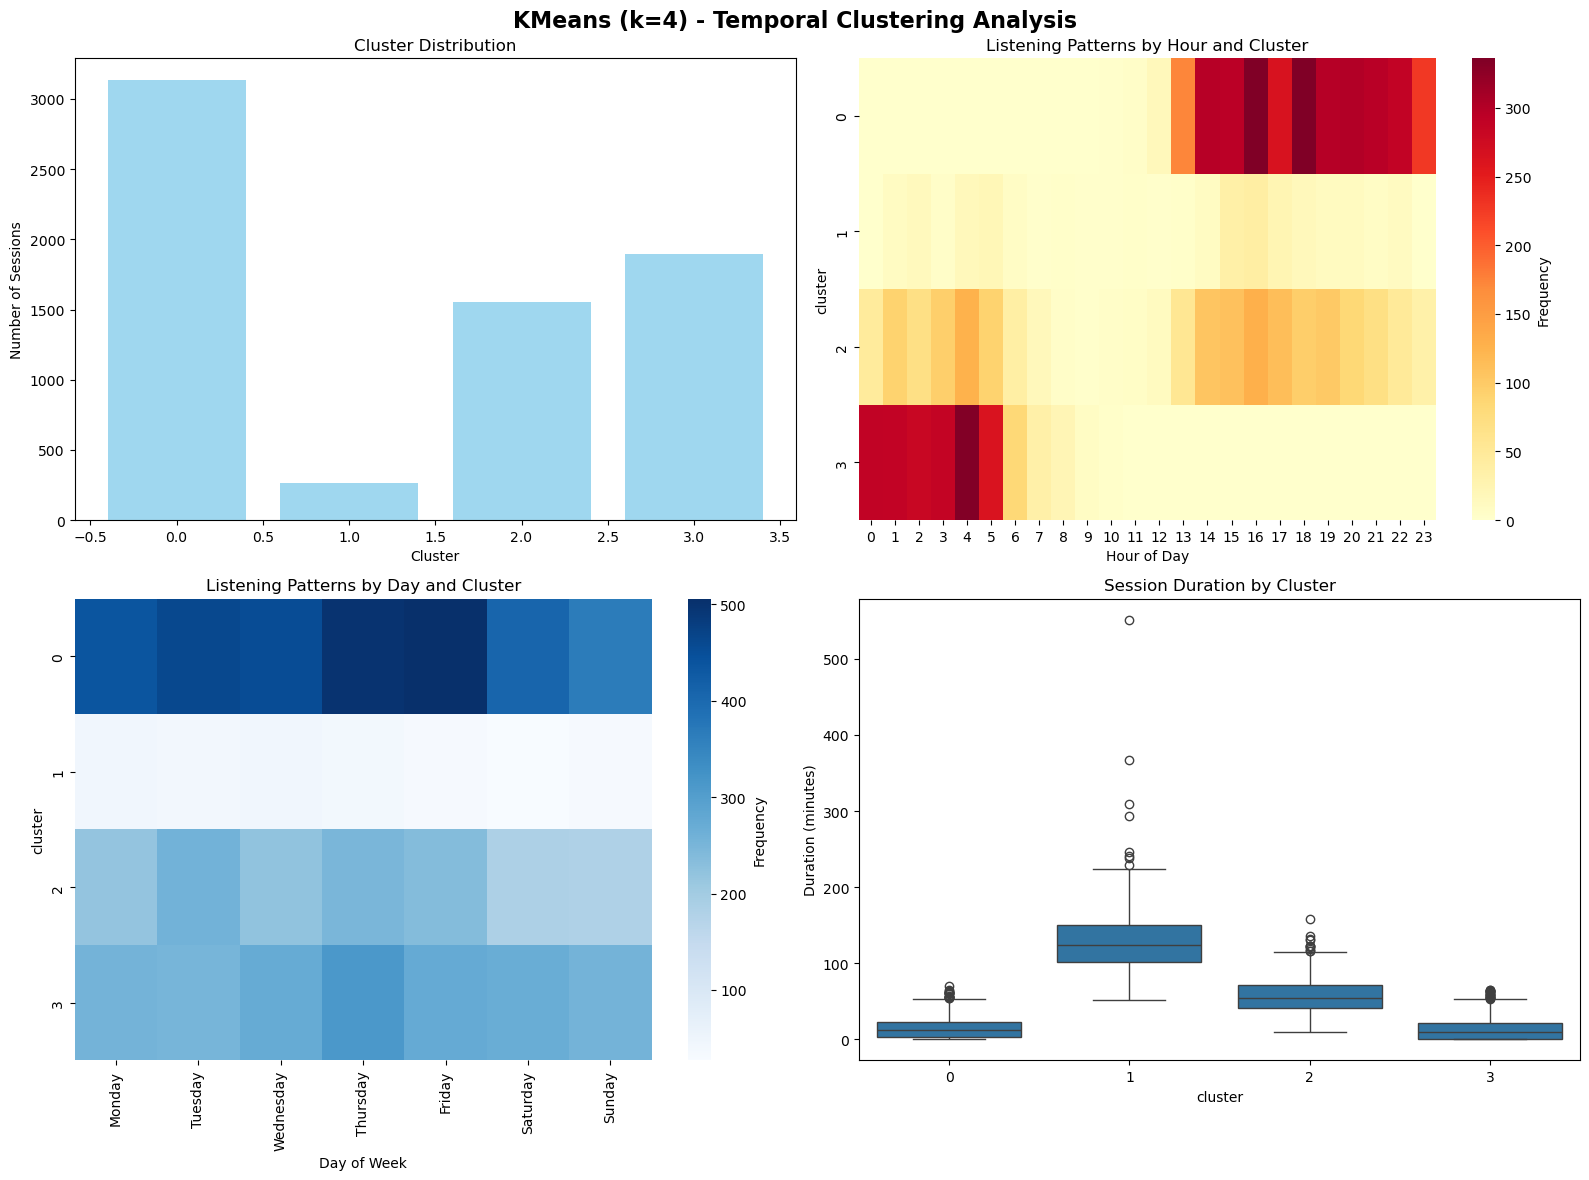

Cluster 0 - Evening Quick Sessions
  Sessions: 3133
  Avg duration: 14.4 min | Avg hour: 18.0
  Common day: Friday | Weekend ratio: 0.25
Cluster 1 - Cluster 1
  Sessions: 262
  Avg duration: 132.8 min | Avg hour: 12.8
  Common day: Monday | Weekend ratio: 0.23
Cluster 2 - Cluster 2
  Sessions: 1551
  Avg duration: 57.9 min | Avg hour: 12.0
  Common day: Tuesday | Weekend ratio: 0.24
Cluster 3 - Late Night Vibes
  Sessions: 1896
  Avg duration: 13.3 min | Avg hour: 2.9
  Common day: Thursday | Weekend ratio: 0.28


In [193]:
# Build session data and run clustering

# Step 1: Build sessions
session_data = create_session_features(all_music, session_gap_minutes=30)

# Step 2: Define features for clustering
clustering_features = [
    # Session characteristics
    'session_duration_minutes', 'unique_artists', 'unique_tracks', 'songs_in_session',
    # Time characteristics (use avg_hour from session)
    'avg_hour',
    # Convert day_of_week to ordinal for clustering
]

# Prepare day_of_week encoding safely
if 'day_of_week' in session_data.columns:
    day_map = {'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6}
    session_data['day_of_week_num'] = session_data['day_of_week'].map(day_map)
    clustering_features.append('day_of_week_num')

# Step 3: Run clustering across algorithms
results, X_scaled, scaler, inertias = perform_temporal_clustering(session_data, clustering_features, n_clusters_range=(2, 6))

# Simple elbow determination (pick 3 or 4 clusters heuristically)
best_k = 4 if len(inertias) >= 3 else 3
best_kmeans = results.get(f'kmeans_{best_k}')

# Step 4: Analyze clusters
if best_kmeans is not None:
    clustered_sessions = analyze_clusters(session_data, best_kmeans.labels_, f'KMeans (k={best_k})')
else:
    # Fallback to GMM
    gmm = results['gmm']
    clustered_sessions = analyze_clusters(session_data, gmm.predict(X_scaled), 'Gaussian Mixture')

# Step 5: Interpret clusters
interpretations = interpret_clusters(clustered_sessions)
for cid, info in interpretations.items():
    print(f"Cluster {cid} - {info['name']}")
    print(f"  Sessions: {info['count']}")
    print(f"  Avg duration: {info['avg_duration_min']} min | Avg hour: {info['avg_hour']}")
    print(f"  Common day: {info['common_day']} | Weekend ratio: {info['weekend_ratio']}")


In order to make it easier to access certain columns I'm going to go through the process of renaming some of them. 

In [194]:
all_music = all_music.rename(columns = {'conn_country': 'country', 
                                        'master_metadata_track_name': 'track', 
                                        'master_metadata_album_artist_name': 'artist',
                                        'master_metadata_album_album_name': 'album'
                                        })
all_music

,year,month,day_of_week,hour,time_of_day,season,date,ts,ms_played,country,track,artist,album,spotify_track_uri,reason_start,reason_end,shuffle,skipped,datetime
0,2018,4,Tuesday,1,Night,Spring,2018-04-17,2018-04-17T01:11:53Z,3250,US,Power,EXO,THE POWER OF MUSIC – The 4th Album ‘THE WAR’ R...,spotify:track:53YZi9zgTnF0Py0K6ejyWz,clickrow,fwdbtn,False,NaN,2018-04-17 01:11:53+00:00
1,2018,4,Tuesday,1,Night,Spring,2018-04-17,2018-04-17T01:11:59Z,5503,US,Me Like Yuh,Jay Park,Everything You Wanted,spotify:track:5S5gGOsUarzRXKoaSstwba,fwdbtn,fwdbtn,False,NaN,2018-04-17 01:11:59+00:00
2,2018,4,Tuesday,1,Night,Spring,2018-04-17,2018-04-17T01:12:08Z,8962,US,RUMOR,KARD,"K.A.R.D Project Vol.3 ""RUMOR""",spotify:track:22iz04Hw1tz0NBpiyoEMT1,fwdbtn,endplay,False,NaN,2018-04-17 01:12:08+00:00
3,2018,4,Tuesday,1,Night,Spring,2018-04-17,2018-04-17T01:12:12Z,3854,US,MIC Drop,BTS,Love Yourself 承 'Her',spotify:track:2SYa5Lx1uoCvyDIW4oee9b,clickrow,endplay,False,NaN,2018-04-17 01:12:12+00:00
4,2018,4,Tuesday,1,Night,Spring,2018-04-17,2018-04-17T01:12:31Z,3088,US,DNA,BTS,Love Yourself 承 'Her',spotify:track:5SE57ljOIUJ1ybL9U6CuBH,clickrow,endplay,False,NaN,2018-04-17 01:12:31+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15954,2023,12,Thursday,21,Evening,Winter,2023-12-07,2023-12-07T21:38:57Z,167989,US,motive (with Doja Cat),Ariana Grande,Positions,spotify:track:5GkQIP5mWPi4KZLLXeuFTT,clickrow,trackdone,False,False,2023-12-07 21:38:57+00:00
15955,2023,12,Thursday,21,Evening,Winter,2023-12-07,2023-12-07T21:39:08Z,9440,US,Señorita,Shawn Mendes,Shawn Mendes,spotify:track:6v3KW9xbzN5yKLt9YKDYA2,trackdone,endplay,False,True,2023-12-07 21:39:08+00:00
15956,2023,12,Thursday,21,Evening,Winter,2023-12-07,2023-12-07T21:42:14Z,185917,US,Houdini,Dua Lipa,Houdini,spotify:track:4OMJGnvZfDvsePyCwRGO7X,clickrow,trackdone,False,False,2023-12-07 21:42:14+00:00
15957,2023,12,Thursday,21,Evening,Winter,2023-12-07,2023-12-07T21:42:18Z,55,US,Sweet Melody,Little Mix,Confetti,spotify:track:76Tuo484SLohJakHLnGI3B,trackdone,logout,False,False,2023-12-07 21:42:18+00:00


### My International Music History <br>

Just out of curiosity I want to see how much time I spend listening to music while traveling over the years and the different countries I've been to. <br>
First I have to adjust the data frame to only include countries that are not the United States as that will most likely lead to the biggest outlier. <br>
Then I'll group my listening history based on the year and country. 

In [195]:
non_us = all_music[all_music['country'] != 'US']
grouped_by_country = non_us.groupby(['year', 'country']).sum(numeric_only=True)
grouped_by_country

month  hour  ms_played  shuffle
year country                                 
2018 IN        1098  1834   26509418      124
     ZZ         552  1255    6788024        0
2019 DE         300   527    2729157        6
     ZZ         128   524    4060551        0
2020 CH          28   213    3456519       16
     CZ          33   386    3842838       30
     DE          13   191    1185845        4
2022 GB         217   480    4877118       12
2023 CA         364   751    8212915       41

Before I can use this information I'll need to convert the milliseconds column into hours.

In [196]:
grouped_by_country_graph = grouped_by_country.reset_index()
grouped_by_country_graph = grouped_by_country_graph.assign(hours_played = (((grouped_by_country_graph['ms_played'] / 1000) /60)/60))
grouped_by_country_graph

,year,country,month,hour,ms_played,shuffle,hours_played
0,2018,IN,1098,1834,26509418,124,7.363727
1,2018,ZZ,552,1255,6788024,0,1.885562
2,2019,DE,300,527,2729157,6,0.758099
3,2019,ZZ,128,524,4060551,0,1.127931
4,2020,CH,28,213,3456519,16,0.960144
5,2020,CZ,33,386,3842838,30,1.067455
6,2020,DE,13,191,1185845,4,0.329401
7,2022,GB,217,480,4877118,12,1.354755
8,2023,CA,364,751,8212915,41,2.281365


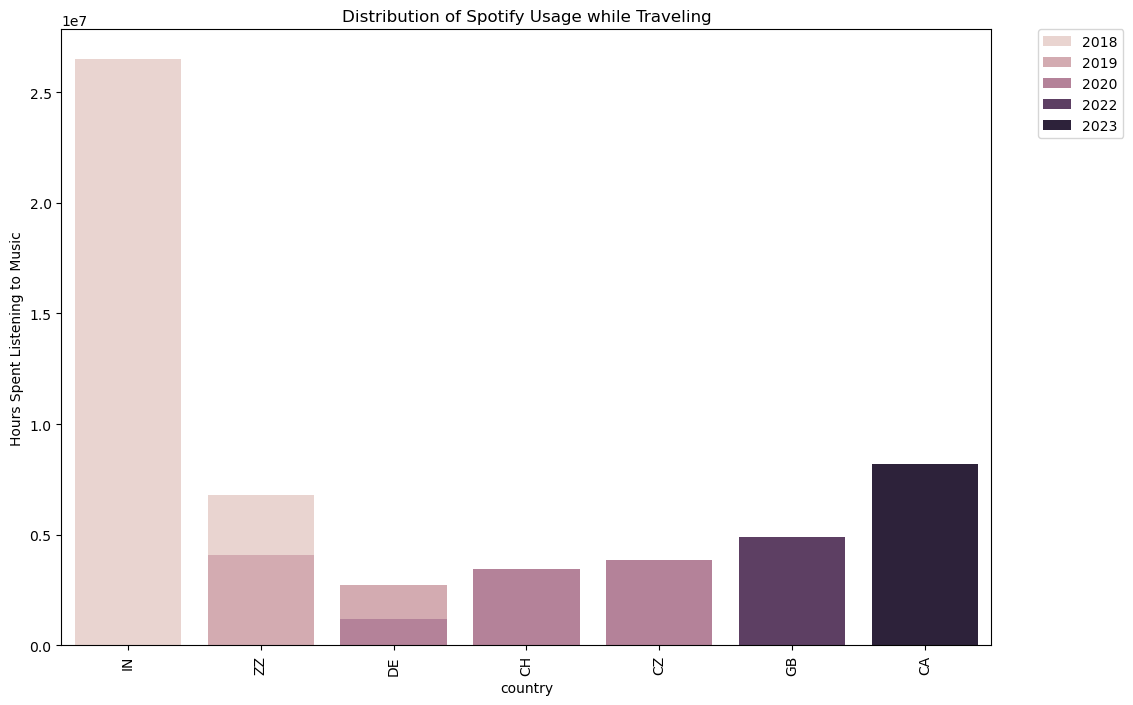

In [197]:
import seaborn as sns
ax = sns.barplot(x='country', y=grouped_by_country_graph['ms_played'], data=grouped_by_country_graph, hue='year', dodge=False)

plt.title("Distribution of Spotify Usage while Traveling")
plt.xticks(rotation=90)
plt.ylabel("Hours Spent Listening to Music")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

### Spotify Usage over the Years <br>
We already determiend that I've spent more than more than 3,000 hours using Spotify since I originally installed it. However that information was my overall listening, meaning both music and podcasts. Let's just look at how much time was spent only listening to music over the years. I'm curious to see if there are any trends that can be explained based on when they occur. 

In [198]:
print(all_music['year'])
all_music.groupby('year').sum(numeric_only=True)['ms_played']

0        2018
1        2018
2        2018
3        2018
4        2018
         ... 
15954    2023
15955    2023
15956    2023
15957    2023
15958    2023
Name: year, Length: 63670, dtype: int32


year
2018     862038314
2019    1441717877
2020    1655212892
2021    1258908797
2022    2424366697
2023    1850412577
Name: ms_played, dtype: int64

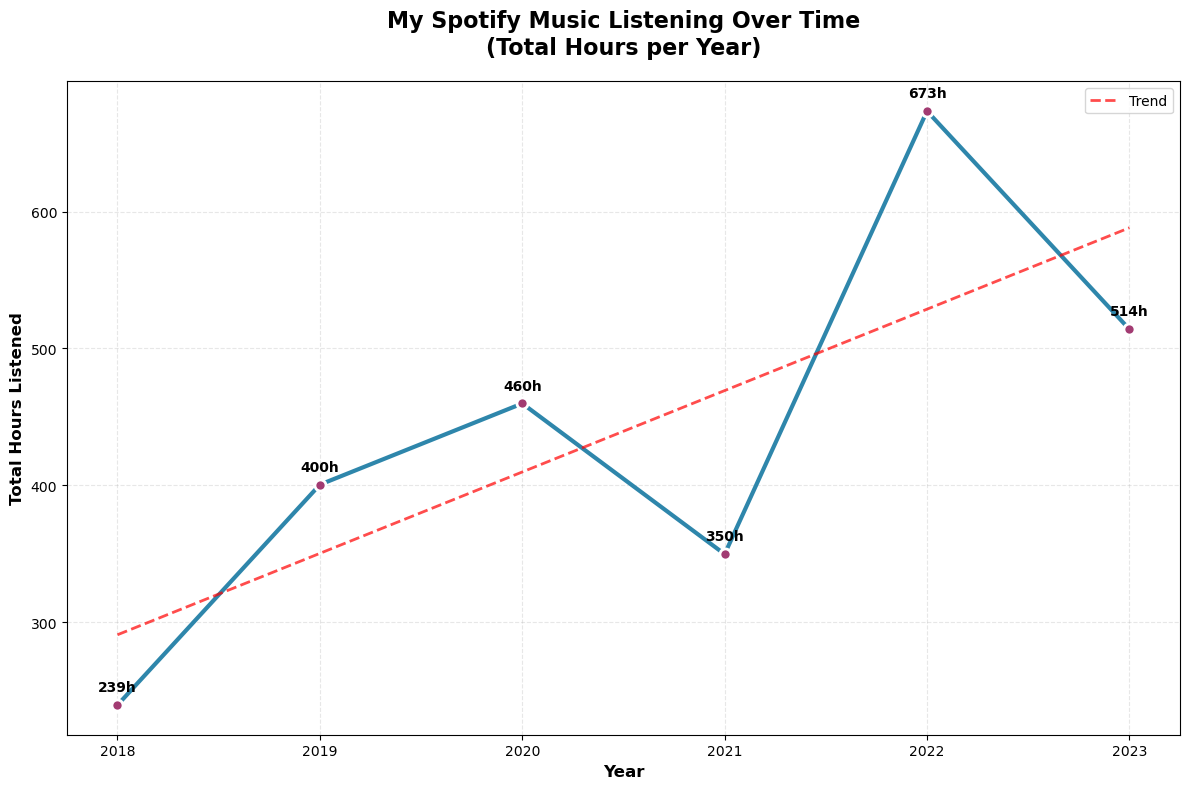


=== Listening Time Summary ===
Total listening time: 2637 hours (110 days)
Average per year: 439 hours
Peak year: 2022 with 673 hours
Lowest year: 2018 with 239 hours


In [199]:
# Create enhanced time series visualization
import matplotlib.pyplot as plt 
import numpy as np 

# Prepare data
x = sorted(all_music['year'].unique())  # X-axis points 
y = all_music.groupby('year').sum(numeric_only=True)['ms_played']  # Y-axis points 

# Convert milliseconds to hours for better readability
y_hours = y / (1000 * 60 * 60)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot with enhanced styling
line = ax.plot(x, y_hours, marker='o', linewidth=3, markersize=8, 
               color='#2E86AB', markerfacecolor='#A23B72', markeredgecolor='white', 
               markeredgewidth=2)

# Customize the plot
ax.set_title("My Spotify Music Listening Over Time\n(Total Hours per Year)", 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Year", fontsize=12, fontweight='bold')
ax.set_ylabel("Total Hours Listened", fontsize=12, fontweight='bold')

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--')

# Add value labels on data points
for i, (year, hours) in enumerate(zip(x, y_hours)):
    ax.annotate(f'{hours:.0f}h', (year, hours), 
                textcoords="offset points", xytext=(0,10), ha='center',
                fontweight='bold', fontsize=10)

# Customize ticks
ax.tick_params(axis='both', labelsize=10)
ax.set_xticks(x)

# Add trend line
z = np.polyfit(x, y_hours, 1)
p = np.poly1d(z)
ax.plot(x, p(x), "--", alpha=0.7, color='red', linewidth=2, label='Trend')
ax.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n=== Listening Time Summary ===")
print(f"Total listening time: {y_hours.sum():.0f} hours ({y_hours.sum()/24:.0f} days)")
print(f"Average per year: {y_hours.mean():.0f} hours")
print(f"Peak year: {x[y_hours.argmax()]} with {y_hours.max():.0f} hours")
print(f"Lowest year: {x[y_hours.argmin()]} with {y_hours.min():.0f} hours") 

From the line plot we can see that my listening time was lowest in 2018 which makes sense given that I did not start using Spotify until April of that year. Then we see that my listneing time reaches a peak at some point between 2019 and 2020. I find it surprising that over 2020 my listening time actually decreased even though it coincides with the pandemic. A potential explanation that I have is that though I was spending a lot more time online I was talking with friends or doing school work rather than listening to music. The time increased again over the next year but seems to have decreased in the last year. The latest decrease in usage is most likely explained by the fact that now when I do not listen to music as much when I do homework and prefer to listen to background noise on YouTube instead. 

I am now curious to determine out of all the BTS songs I have listened to, which one is my all time favorite? <br> We start with the songs dataframe and query out only songs by BTS. 

In [200]:
alltime_BTS = all_music[all_music['artist'] == 'BTS']
alltime_BTS

,year,month,day_of_week,hour,time_of_day,season,date,ts,ms_played,country,track,artist,album,spotify_track_uri,reason_start,reason_end,shuffle,skipped,datetime
3,2018,4,Tuesday,1,Night,Spring,2018-04-17,2018-04-17T01:12:12Z,3854,US,MIC Drop,BTS,Love Yourself 承 'Her',spotify:track:2SYa5Lx1uoCvyDIW4oee9b,clickrow,endplay,False,NaN,2018-04-17 01:12:12+00:00
4,2018,4,Tuesday,1,Night,Spring,2018-04-17,2018-04-17T01:12:31Z,3088,US,DNA,BTS,Love Yourself 承 'Her',spotify:track:5SE57ljOIUJ1ybL9U6CuBH,clickrow,endplay,False,NaN,2018-04-17 01:12:31+00:00
5,2018,4,Tuesday,1,Night,Spring,2018-04-17,2018-04-17T01:19:34Z,10077,US,Blood Sweat & Tears,BTS,Wings,spotify:track:5RGf8qn1TBWVplLyyKUsuV,clickrow,endplay,False,NaN,2018-04-17 01:19:34+00:00
7,2018,4,Tuesday,3,Night,Spring,2018-04-17,2018-04-17T03:29:37Z,235779,US,Go Go,BTS,Love Yourself 承 'Her',spotify:track:5nq1uTNIR1cBR72T87viS0,clickrow,trackdone,True,NaN,2018-04-17 03:29:37+00:00
8,2018,4,Tuesday,3,Night,Spring,2018-04-17,2018-04-17T03:33:25Z,227413,US,Don't Leave Me,BTS,FACE YOURSELF,spotify:track:3zIG0WuI5RoJsFYnErkFDU,trackdone,trackdone,True,NaN,2018-04-17 03:33:25+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15745,2023,12,Monday,8,Morning,Winter,2023-12-04,2023-12-04T08:35:28Z,196776,US,dimple,BTS,Love Yourself 承 'Her',spotify:track:6pp6xf9zS55GD4nr318XUH,trackdone,trackdone,False,False,2023-12-04 08:35:28+00:00
15748,2023,12,Monday,8,Morning,Winter,2023-12-04,2023-12-04T08:45:27Z,253303,US,Heartbeat (BTS World Original Soundtrack),BTS,BTS WORLD (Original Soundtrack),spotify:track:4ZISkGo0j60iyLbme2rAkC,trackdone,trackdone,False,False,2023-12-04 08:45:27+00:00
15749,2023,12,Monday,8,Morning,Winter,2023-12-04,2023-12-04T08:55:56Z,27149,US,Converse High,BTS,The Most Beautiful Moment in Life Pt.1,spotify:track:6ZITsss1URNOIKhniylpBP,trackdone,logout,False,False,2023-12-04 08:55:56+00:00
15786,2023,12,Monday,22,Night,Winter,2023-12-04,2023-12-04T22:33:22Z,141781,US,Answer : Love Myself,BTS,Love Yourself 結 'Answer',spotify:track:2X3UgVLSA4wYriGIQyYmMA,clickrow,logout,False,False,2023-12-04 22:33:22+00:00


In [201]:
# Export key datasets for the Streamlit app (robust to missing pyarrow)
import os

EXPORT_DIR = 'data'
os.makedirs(EXPORT_DIR, exist_ok=True)

# Helper to write parquet if available
def safe_to_parquet(df: pd.DataFrame, path: str) -> bool:
    try:
        import pyarrow  # noqa
        df.to_parquet(path)
        return True
    except Exception as e:
        print(f"Parquet export skipped ({e}); CSV will be used instead.")
        return False

# Export all_music
if 'all_music' in globals() and isinstance(all_music, pd.DataFrame):
    wrote_parquet = safe_to_parquet(all_music, os.path.join(EXPORT_DIR, 'all_music.parquet'))
    all_music.to_csv(os.path.join(EXPORT_DIR, 'all_music.csv'), index=False)
    print('Saved: data/all_music.csv' + (' and all_music.parquet' if wrote_parquet else ''))
else:
    print('Warning: all_music not found; run earlier cells first.')

# Export clustered_sessions if available
if 'clustered_sessions' in globals() and isinstance(clustered_sessions, pd.DataFrame):
    wrote_parquet = safe_to_parquet(clustered_sessions, os.path.join(EXPORT_DIR, 'clustered_sessions.parquet'))
    clustered_sessions.to_csv(os.path.join(EXPORT_DIR, 'clustered_sessions.csv'), index=False)
    print('Saved: data/clustered_sessions.csv' + (' and clustered_sessions.parquet' if wrote_parquet else ''))
else:
    print('Note: clustered_sessions not found yet. Run the clustering section if you want that page populated.')


Saved: data/all_music.csv and all_music.parquet
Saved: data/clustered_sessions.csv and clustered_sessions.parquet


In [202]:
alltime_BTS_counts = alltime_BTS.groupby('track').count().sort_values('album', ascending=False)
alltime_BTS_counts
favorite_BTS_song = alltime_BTS_counts.index[0]
favorite_BTS_song

'BTS Cypher 4'

From this I have determined that my all time favorite BTS song is 'ON'. The following is a list of my top 10 BTS songs over the years. 

In [203]:
top_10_BTS_alltime = alltime_BTS_counts.reset_index().take(np.arange(10))
top_10_BTS_alltime = top_10_BTS_alltime['track']
top_10_BTS_alltime

0     BTS Cypher 4
1               ON
2       Black Swan
3           Filter
4             IDOL
5        FAKE LOVE
6    Make It Right
7           dimple
8        Not Today
9       Pied Piper
Name: track, dtype: object

## Limitations and Future Work

### Current Limitations

1. **Data Scope**: This analysis is limited to the data provided by Spotify's export feature, which may not include all listening history
2. **API Rate Limits**: Spotify Web API has rate limits that restrict the amount of metadata that can be retrieved
3. **Temporal Gaps**: Some periods may have incomplete data due to account changes or technical issues
4. **Context Missing**: The data doesn't include context about why certain songs were played (mood, activity, social setting)

### Future Enhancements

1. **Advanced Analytics**: 
   - Machine learning models to predict listening preferences
   - Sentiment analysis of lyrics to understand emotional patterns
   - Clustering analysis to identify different listening modes

2. **Interactive Dashboard**: 
   - Create a web-based dashboard using Streamlit or Dash
   - Add filtering and drill-down capabilities
   - Real-time updates with new data

3. **Comparative Analysis**:
   - Compare personal trends with global Spotify trends
   - Analyze how listening patterns correlate with life events
   - Study the impact of social features on music discovery

4. **Extended Data Sources**:
   - Incorporate playlist data
   - Add social listening data
   - Include podcast listening patterns

### Data Privacy Note

This analysis uses personal data exported from Spotify. All analysis is performed locally, and no personal information is shared with third parties. The code is designed to work with your own exported data files.
